In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None) # Display any number of columns
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

import matplotlib as mpl # Additional plotting functionality
mpl.rcParams['figure.dpi'] = 400 # High resolution figures

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore") 

from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold

from sklearn.metrics import recall_score, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix, roc_auc_score, roc_curve

import lightgbm as lgb
from sklearn import metrics

Read the file 

In [2]:
df = pd.read_csv('output/LC_Final.csv.gz',compression='gzip',low_memory=True)

In [3]:
df.sample(3)

,Unnamed: 0,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mo_sin_old_il_acct,mort_acc,earliest_cr_year,fico_score,charged_off
459125,679110,10000.0,36,7.39,A4,5.0,MORTGAGE,4.672107,Not Verified,debt_consolidation,IN,22.29,17.0,0.0,4.035029,29.9,f,Individual,76.0,1.0,2001,732.0,0
1340230,2252030,21000.0,60,24.49,E3,10.0,OWN,4.877377,Source Verified,home_improvement,NJ,22.71,13.0,1.0,0.000000,0.0,f,Individual,137.0,2.0,2002,672.0,1
466252,689973,14950.0,36,14.46,C4,10.0,MORTGAGE,4.531492,Source Verified,home_improvement,MI,15.65,7.0,0.0,3.766115,39.7,w,Individual,105.0,3.0,2004,687.0,1


In [4]:
df = df.drop('Unnamed: 0', axis=1)

# Feature Engineering
- Converting features to categorical
- Dropping NaN values

Convert all the object columns to categorial. The biggest advantage with LightGBM is that we don't need to use one hot encoding. All the categorical features automatically be label-encoded and passed to the internal category handling in lightgbm. This behavior is triggered by **categorical_feature='auto**, that is default.

In [5]:
df.select_dtypes(['object']).columns

Index(['sub_grade', 'home_ownership', 'verification_status', 'purpose',
       'addr_state', 'initial_list_status', 'application_type'],
      dtype='object')

In [6]:
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1345310 entries, 0 to 1345309
Data columns (total 22 columns):
 #   Column               Non-Null Count    Dtype   
---  ------               --------------    -----   
 0   loan_amnt            1345310 non-null  float64 
 1   term                 1345310 non-null  int64   
 2   int_rate             1345310 non-null  float64 
 3   sub_grade            1345310 non-null  category
 4   emp_length           1266799 non-null  float64 
 5   home_ownership       1345310 non-null  category
 6   annual_inc           1345310 non-null  float64 
 7   verification_status  1345310 non-null  category
 8   purpose              1345310 non-null  category
 9   addr_state           1345310 non-null  category
 10  dti                  1344936 non-null  float64 
 11  open_acc             1345310 non-null  float64 
 12  pub_rec              1345310 non-null  float64 
 13  revol_bal            1345310 non-null  float64 
 14  revol_util           1344453 non-n

#### Check if there are any missing values

df.isnull().any() generates a boolean array (True if the column has a missing value, False otherwise). You can use it to index into df.columns:

In [8]:
df.columns[df.isnull().any()]

Index(['emp_length', 'dti', 'revol_util', 'mo_sin_old_il_acct', 'mort_acc'], dtype='object')

In [9]:
df = df.dropna(how='any')
df.shape

(1167952, 22)

In [10]:
df.sample(2)

,loan_amnt,term,int_rate,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,initial_list_status,application_type,mo_sin_old_il_acct,mort_acc,earliest_cr_year,fico_score,charged_off
1300276,12000.0,60,12.74,C1,8.0,MORTGAGE,5.232999,Verified,credit_card,TX,12.58,21.0,1.0,4.281488,54.6,w,Individual,132.0,1.0,1993,702.0,0
780527,21000.0,60,15.61,D1,3.0,RENT,5.021193,Verified,debt_consolidation,OR,25.39,17.0,0.0,4.715360,59.4,f,Individual,49.0,0.0,2004,702.0,0


### Class Balance

In [11]:
df['charged_off'].value_counts()

0    937174
1    230778
Name: charged_off, dtype: int64

In [12]:
df['charged_off'].value_counts(normalize=True, dropna=False)

0    0.802408
1    0.197592
Name: charged_off, dtype: float64

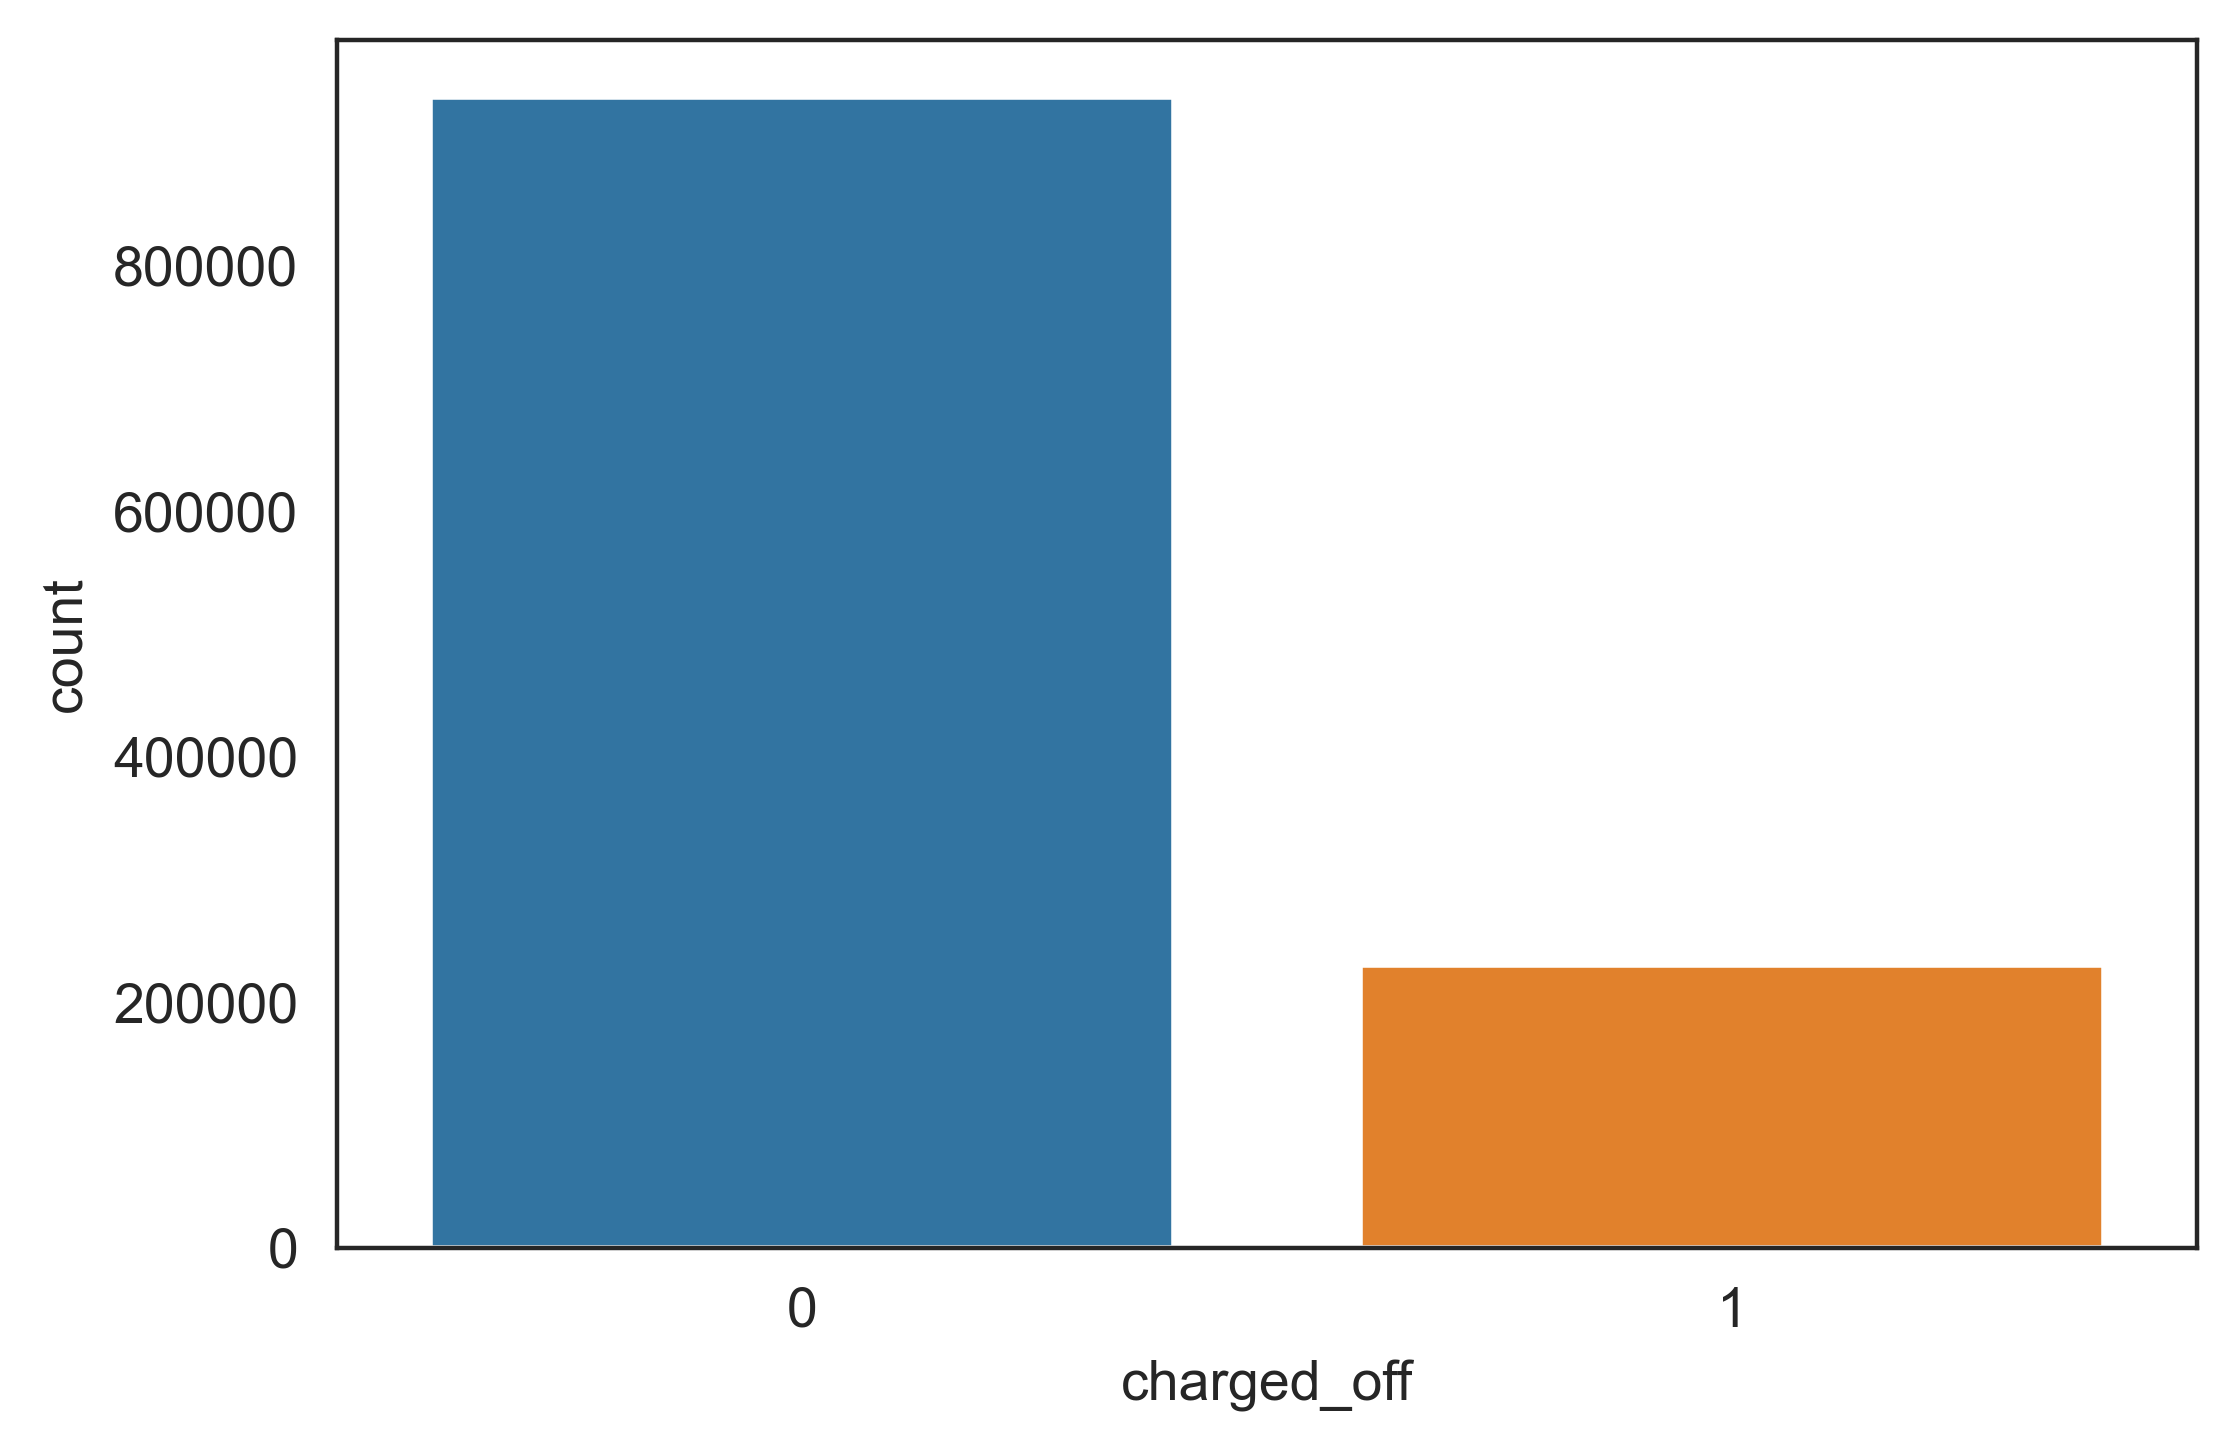

In [13]:
sns.countplot(x='charged_off',data=df)
plt.ticklabel_format(style='plain', axis='y')

It is clearly evident that Loan-status class is imbalanced. To solve the problem of unbalance class issue there are many techniques that can be applied. 

- There are two parameters in lightgbm that allow you to deal with this issue is_unbalance and scale_pos_weight. We are using is_unbalance parameter for our model

- The other option that we are trying here is upsampling the minority class

#### Train Test Split

In [14]:
X = df.drop('charged_off', axis = 1)
y = df.charged_off

Set X and y variables to the .values of the features and label.
- stratify parameter will preserve the proportion of target as in original dataset, in the train and test datasets as well.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1022, stratify = y)

In [16]:
lgb_params = {
    'n_estimators': 8000,
    'max_depth': 63,
    'objective': 'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 250,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 1,
    'categorical_feature':'auto',
    'boosting_type' : 'gbdt'
}

In [17]:
lgbm_unbal = lgb.LGBMClassifier(**lgb_params)

In [18]:
lgbm_unbal.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, categorical_feature='auto',
               feature_fraction=0.64, learning_rate=0.02, max_depth=63,
               n_estimators=8000, num_leaves=250, objective='binary')

<AxesSubplot:>

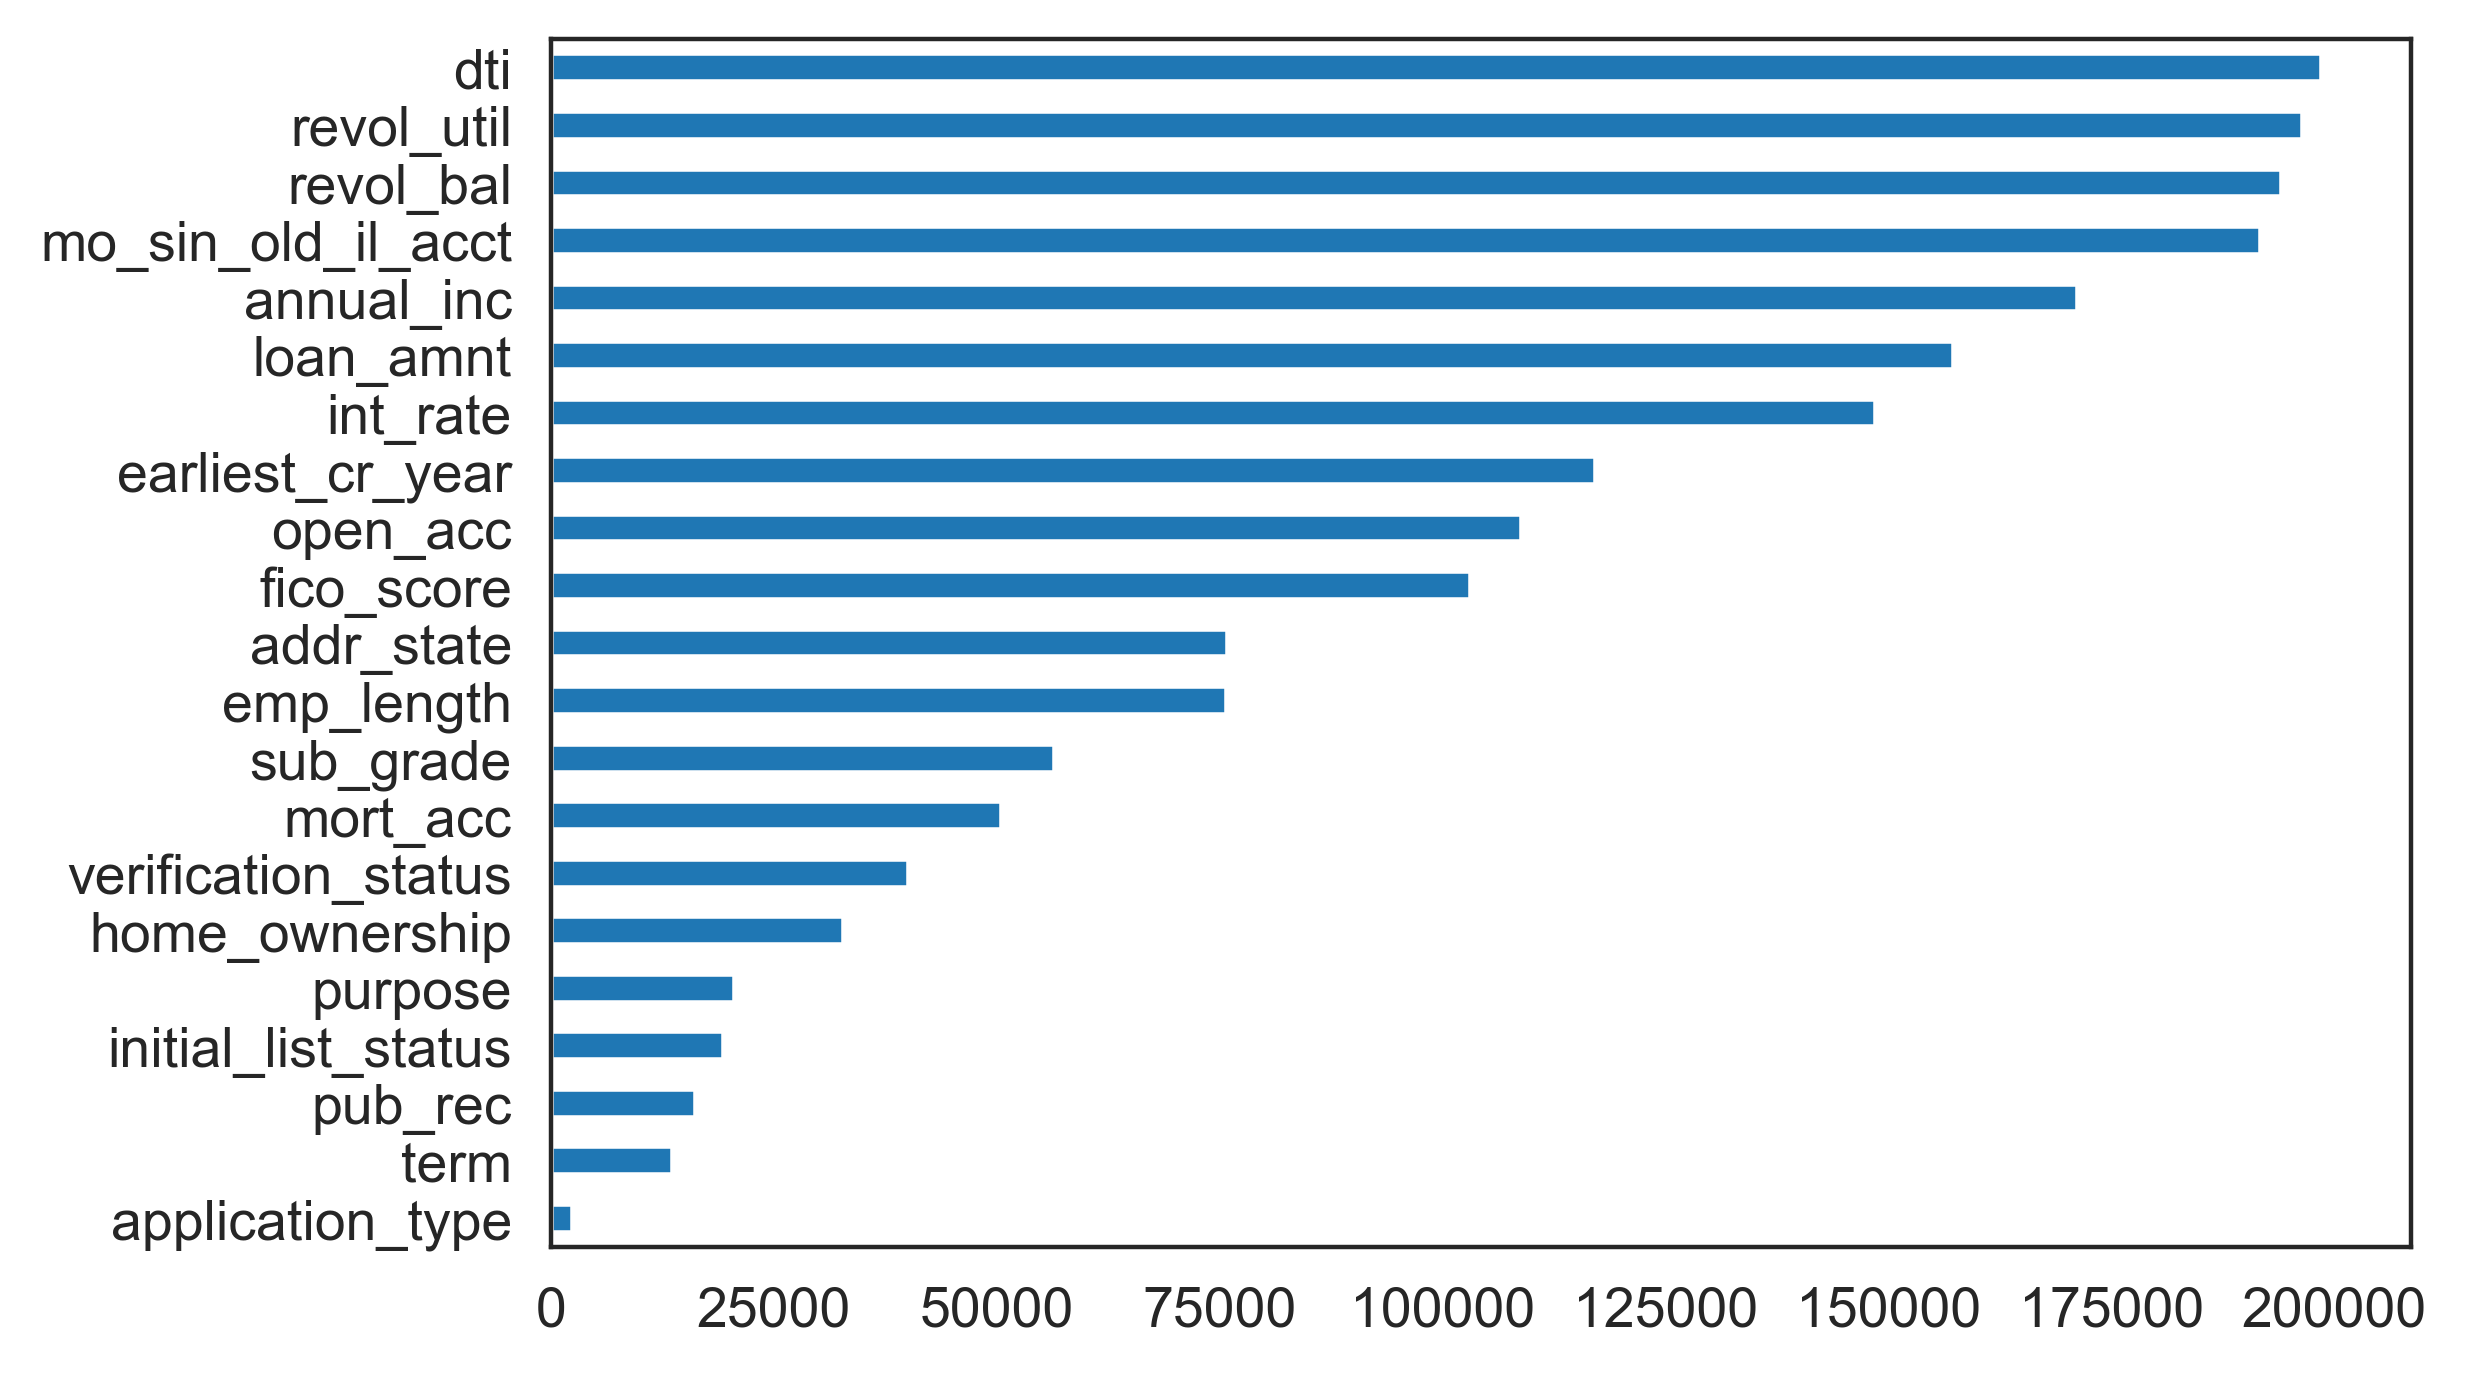

In [19]:
feat_imp = pd.Series(lgbm_unbal.feature_importances_, index=X.columns)
feat_imp.nsmallest(21).plot(kind='barh')

In [20]:
lgb_unbal_pred = lgbm_unbal.predict(X_test)

In [21]:
lgb_unbal_pred_proba = lgbm_unbal.predict_proba(X_test)

**Create a reusable function for evaluating the models and print the evaluation criteria:**
    - Accuracy
    - ROC-AUC score
    - Confusion matrix 
    - Classification report.

In [22]:
def evaluate_model(y_test, y_pred, y_pred_proba = None):
    if y_pred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, y_pred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, y_pred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))

- Precision = True Positives / (True Positives + False Positives)
- Recall = True Positives / (True Positives + False Negatives)
- F1 score: calculates the harmonic mean of the precision and recall
            F-measure = 2 (Recall * Precision) / (Recall + Precision)
- accuracy: (TP + TN) / (TP + FP + TN + FN)
- average=macro says the function to compute f1 for each label, and returns the average without considering the proportion for   
  each label in the dataset.
- average=weighted says the function to compute f1 for each label, and returns the average considering the proportion for each 
  label in the dataset.
- Confusion matrix: 
                    Actual 
          Predicted [TP|FP]
                    [FN|TN]                   

In [23]:
evaluate_model(y_test, lgb_unbal_pred, lgb_unbal_pred_proba)

ROC-AUC score of the model: 0.7254064094435675
Accuracy of the model: 0.8064060413027844

Classification report: 
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     93718
           1       0.55      0.12      0.19     23078

    accuracy                           0.81    116796
   macro avg       0.68      0.55      0.54    116796
weighted avg       0.76      0.81      0.75    116796


Confusion matrix: 
[[91527  2191]
 [20420  2658]]



In [24]:
pos_unbal_proba = lgb_unbal_pred_proba[:,1]
pos_unbal_proba

array([0.34533416, 0.34389252, 0.07481782, ..., 0.14976325, 0.03791985,
       0.26635081])

In [25]:
unbal_fpr, unbal_tpr, unbal_thresholds = metrics.roc_curve(y_test, pos_unbal_proba)

Text(0.5, 1.0, 'ROC Curve (Area = 0.73)')

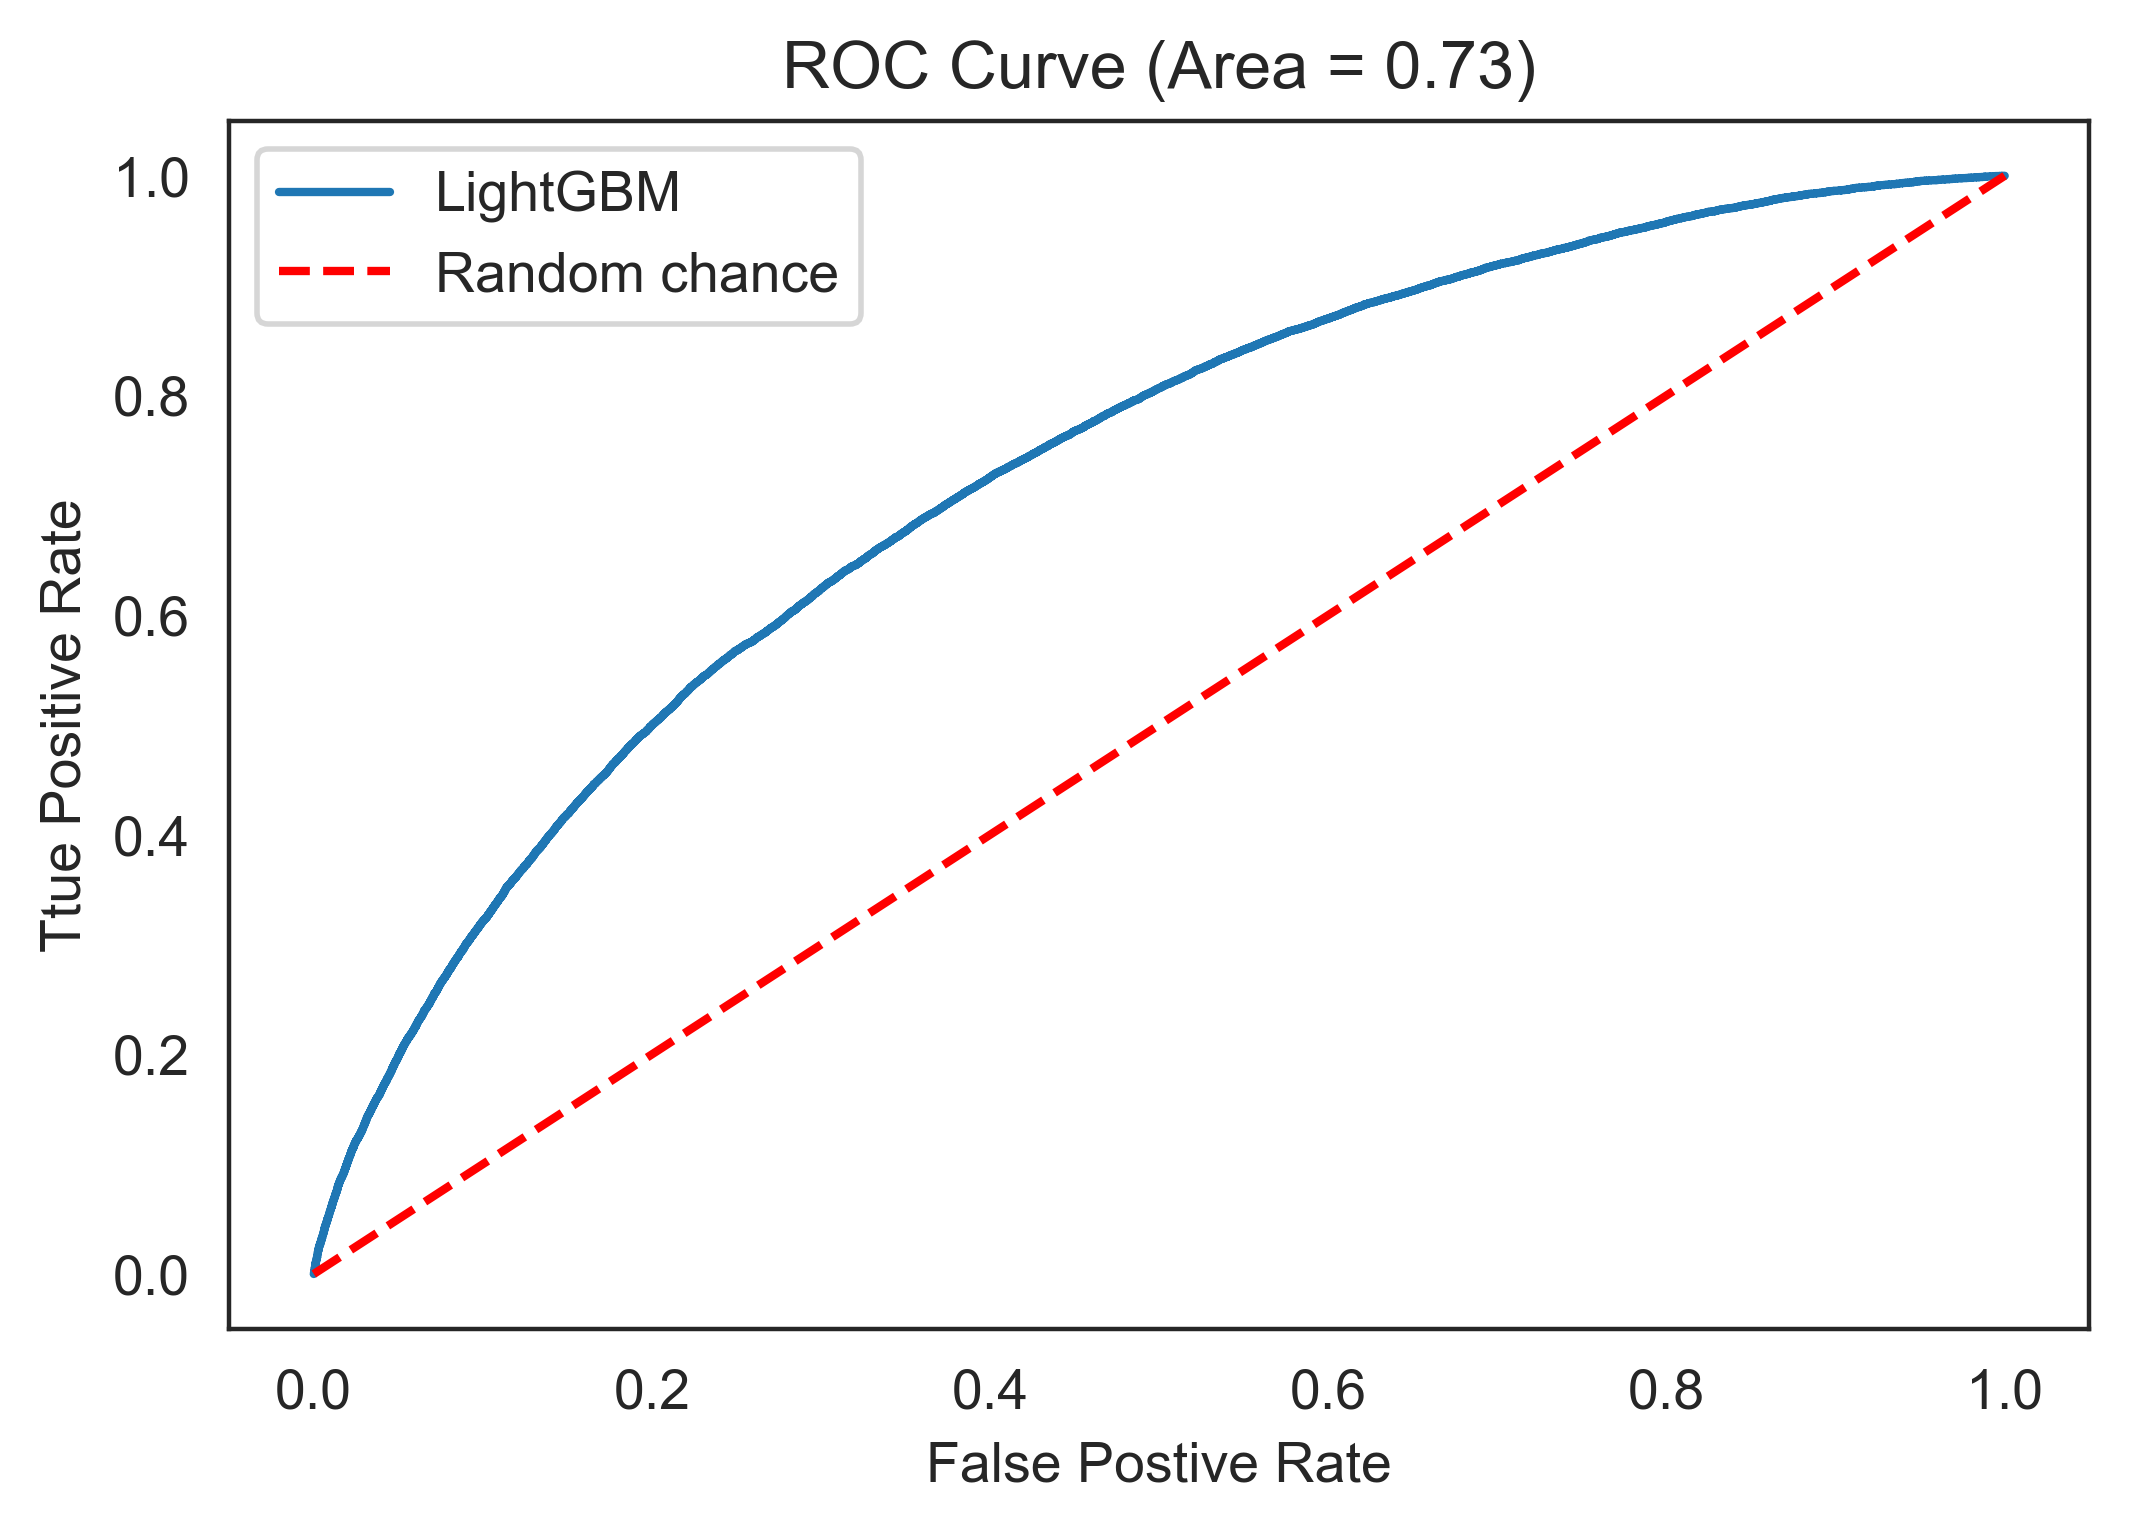

In [26]:
roc_auc_unbal = roc_auc_score(y_test, pos_unbal_proba)
plt.plot(unbal_fpr, unbal_tpr, '-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['LightGBM', 'Random chance'])
plt.xlabel('False Postive Rate')
plt.ylabel('Ttue Positive Rate')
plt.title('ROC Curve (Area = {:.2f})'.format(roc_auc_unbal))

In [27]:
unbal_precision, unbal_recall, unbal_thresh_3 = metrics.precision_recall_curve(y_test, pos_unbal_proba)

(0.0, 1.0)

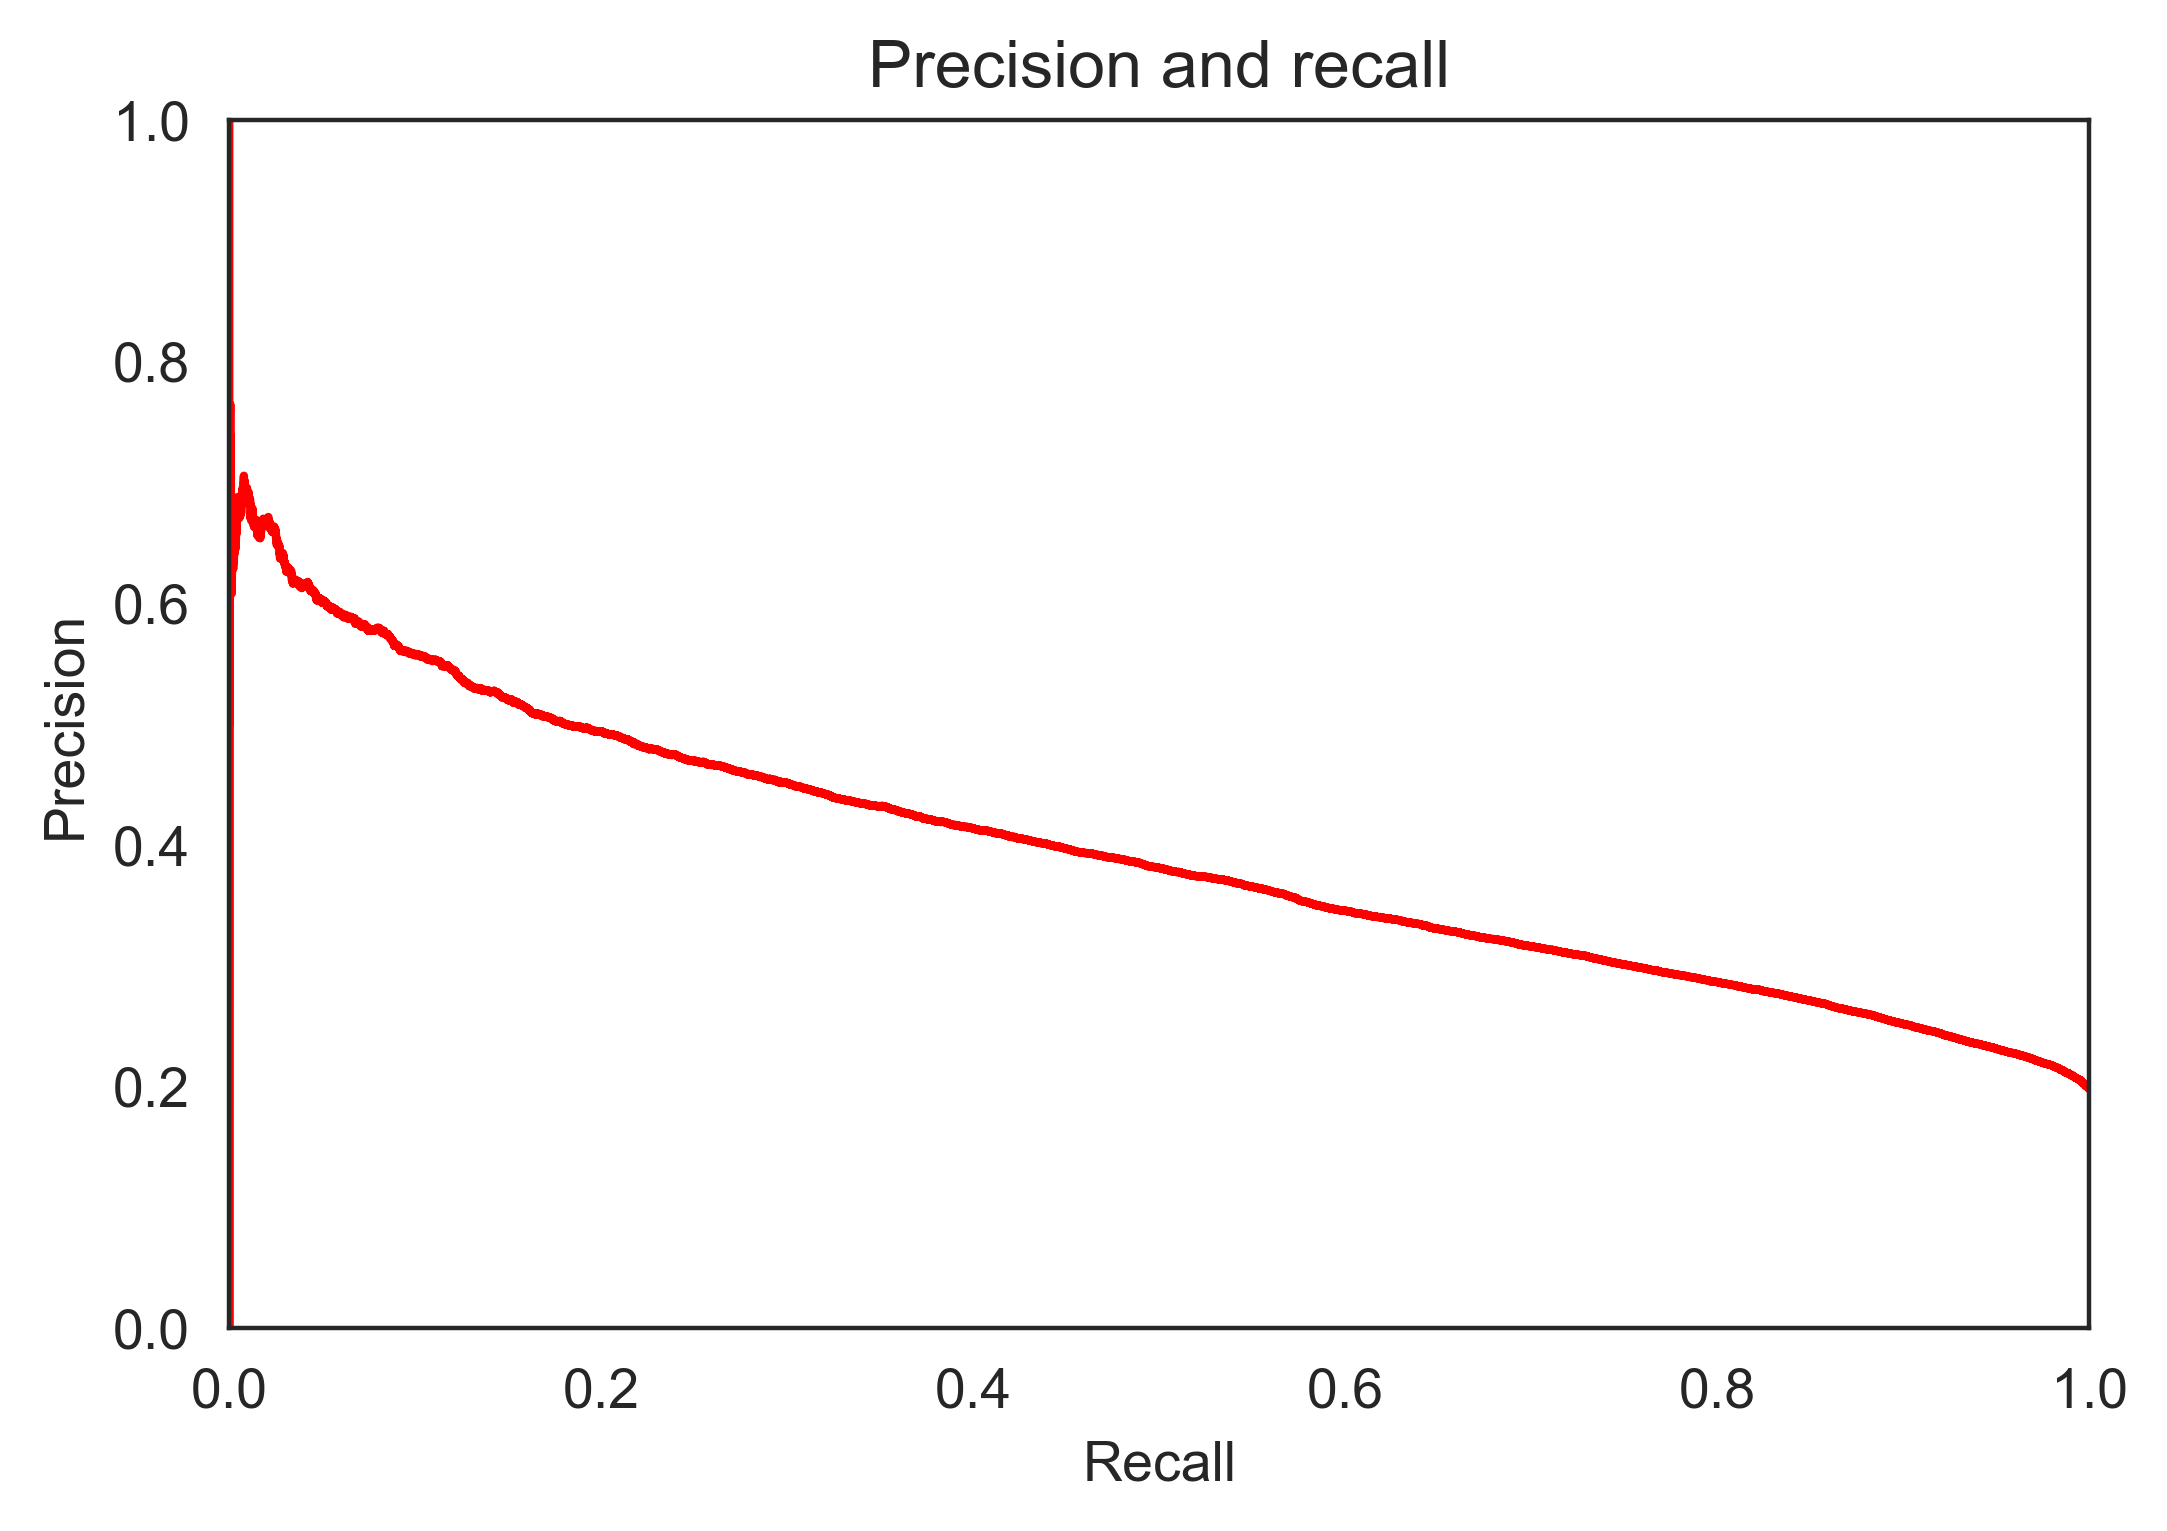

In [28]:
plt.plot(unbal_recall, unbal_precision, 'r-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and recall')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [30]:
metrics.auc(unbal_recall, unbal_precision)

0.39276887461426785

**Now let's try LightGBM's is_balance parameter**

In [31]:
lgb_bal_params = {
    'n_estimators': 8000,
    'max_depth': 63,
    'objective': 'binary',
    'is_unbalance':True,
    'learning_rate' : 0.02,
    'num_leaves' : 250,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 1,
    'categorical_feature':'auto',
    'boosting_type' : 'gbdt'
}

In [32]:
lgbm_bal = lgb.LGBMClassifier(**lgb_bal_params)

In [33]:
lgbm_bal.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, categorical_feature='auto',
               feature_fraction=0.64, is_unbalance=True, learning_rate=0.02,
               max_depth=63, n_estimators=8000, num_leaves=250,
               objective='binary')

<AxesSubplot:>

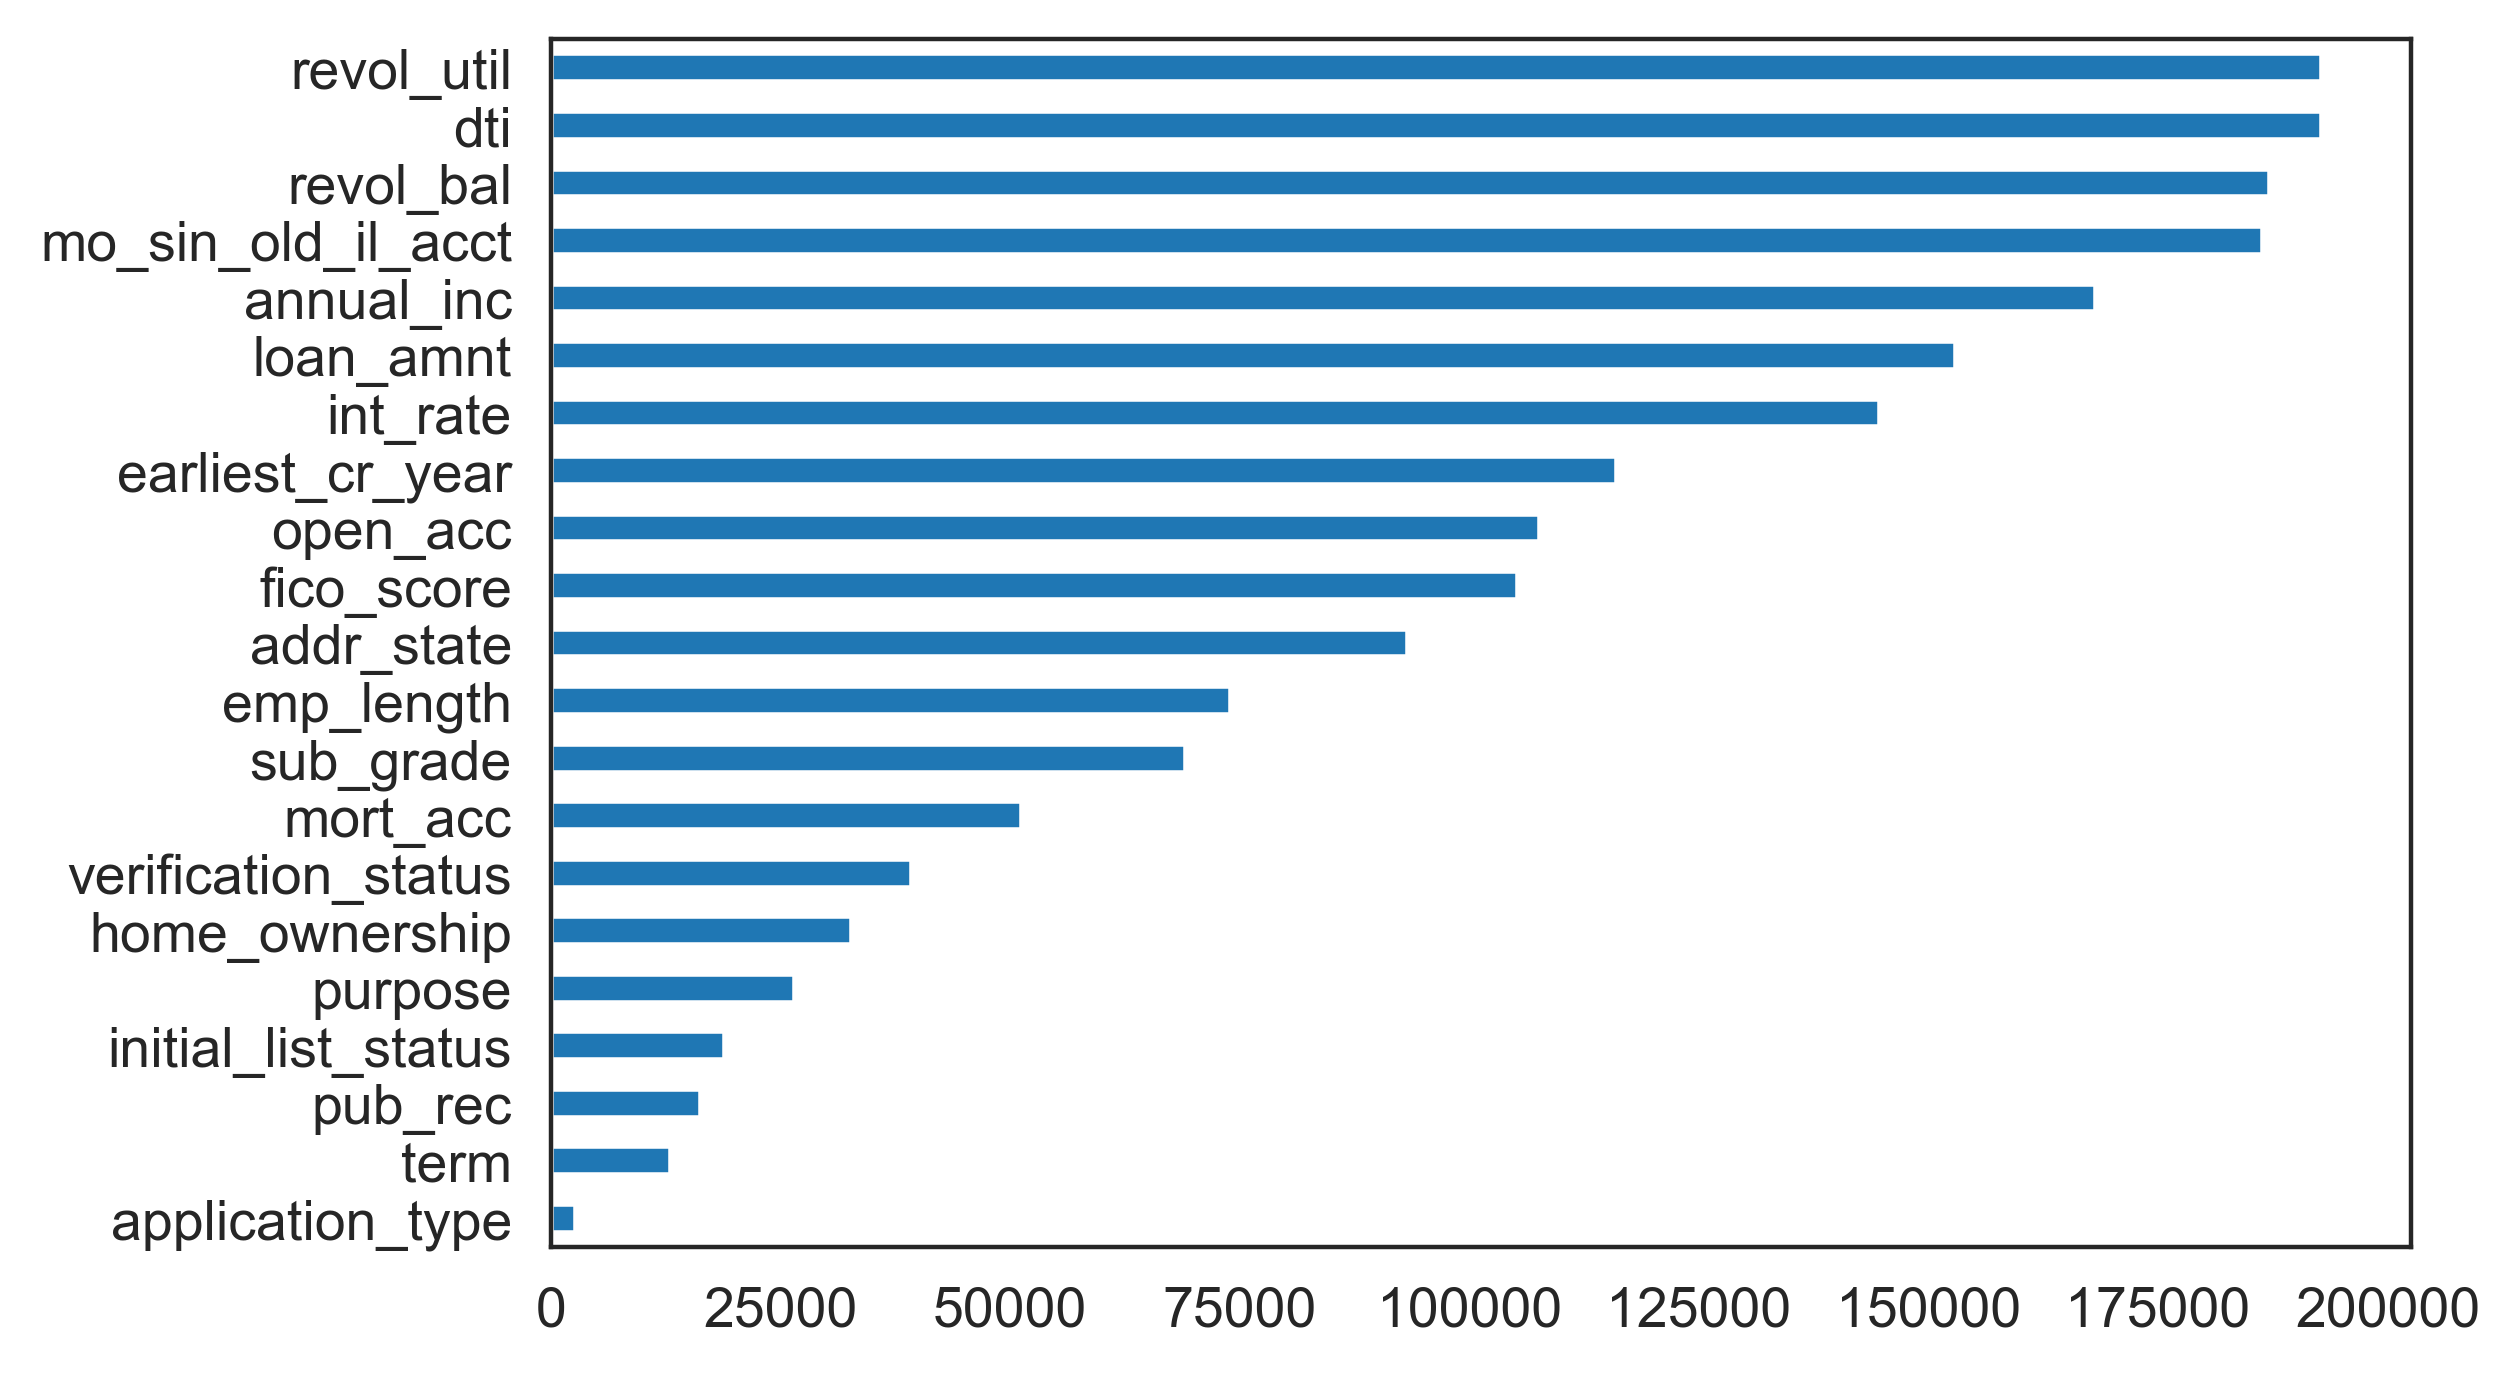

In [34]:
feat_imp = pd.Series(lgbm_bal.feature_importances_, index=X.columns)
feat_imp.nsmallest(21).plot(kind='barh')

In [35]:
lgb_bal_pred = lgbm_bal.predict(X_test)

In [36]:
lgb_bal_pred_proba = lgbm_bal.predict_proba(X_test)

In [37]:
evaluate_model(y_test, lgb_bal_pred, lgb_bal_pred_proba)

ROC-AUC score of the model: 0.7227983183600731
Accuracy of the model: 0.7310952429877735

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     93718
           1       0.37      0.51      0.43     23078

    accuracy                           0.73    116796
   macro avg       0.62      0.65      0.63    116796
weighted avg       0.77      0.73      0.75    116796


Confusion matrix: 
[[73548 20170]
 [11237 11841]]



In [38]:
pos_bal_proba = lgb_bal_pred_proba[:,1]
pos_bal_proba

array([0.63993663, 0.63106164, 0.31985914, ..., 0.29380789, 0.0799022 ,
       0.40582377])

In [39]:
bal_fpr, bal_tpr, bal_thresholds = metrics.roc_curve(y_test, pos_bal_proba)

Text(0.5, 1.0, 'ROC Curve (Area = 0.72)')

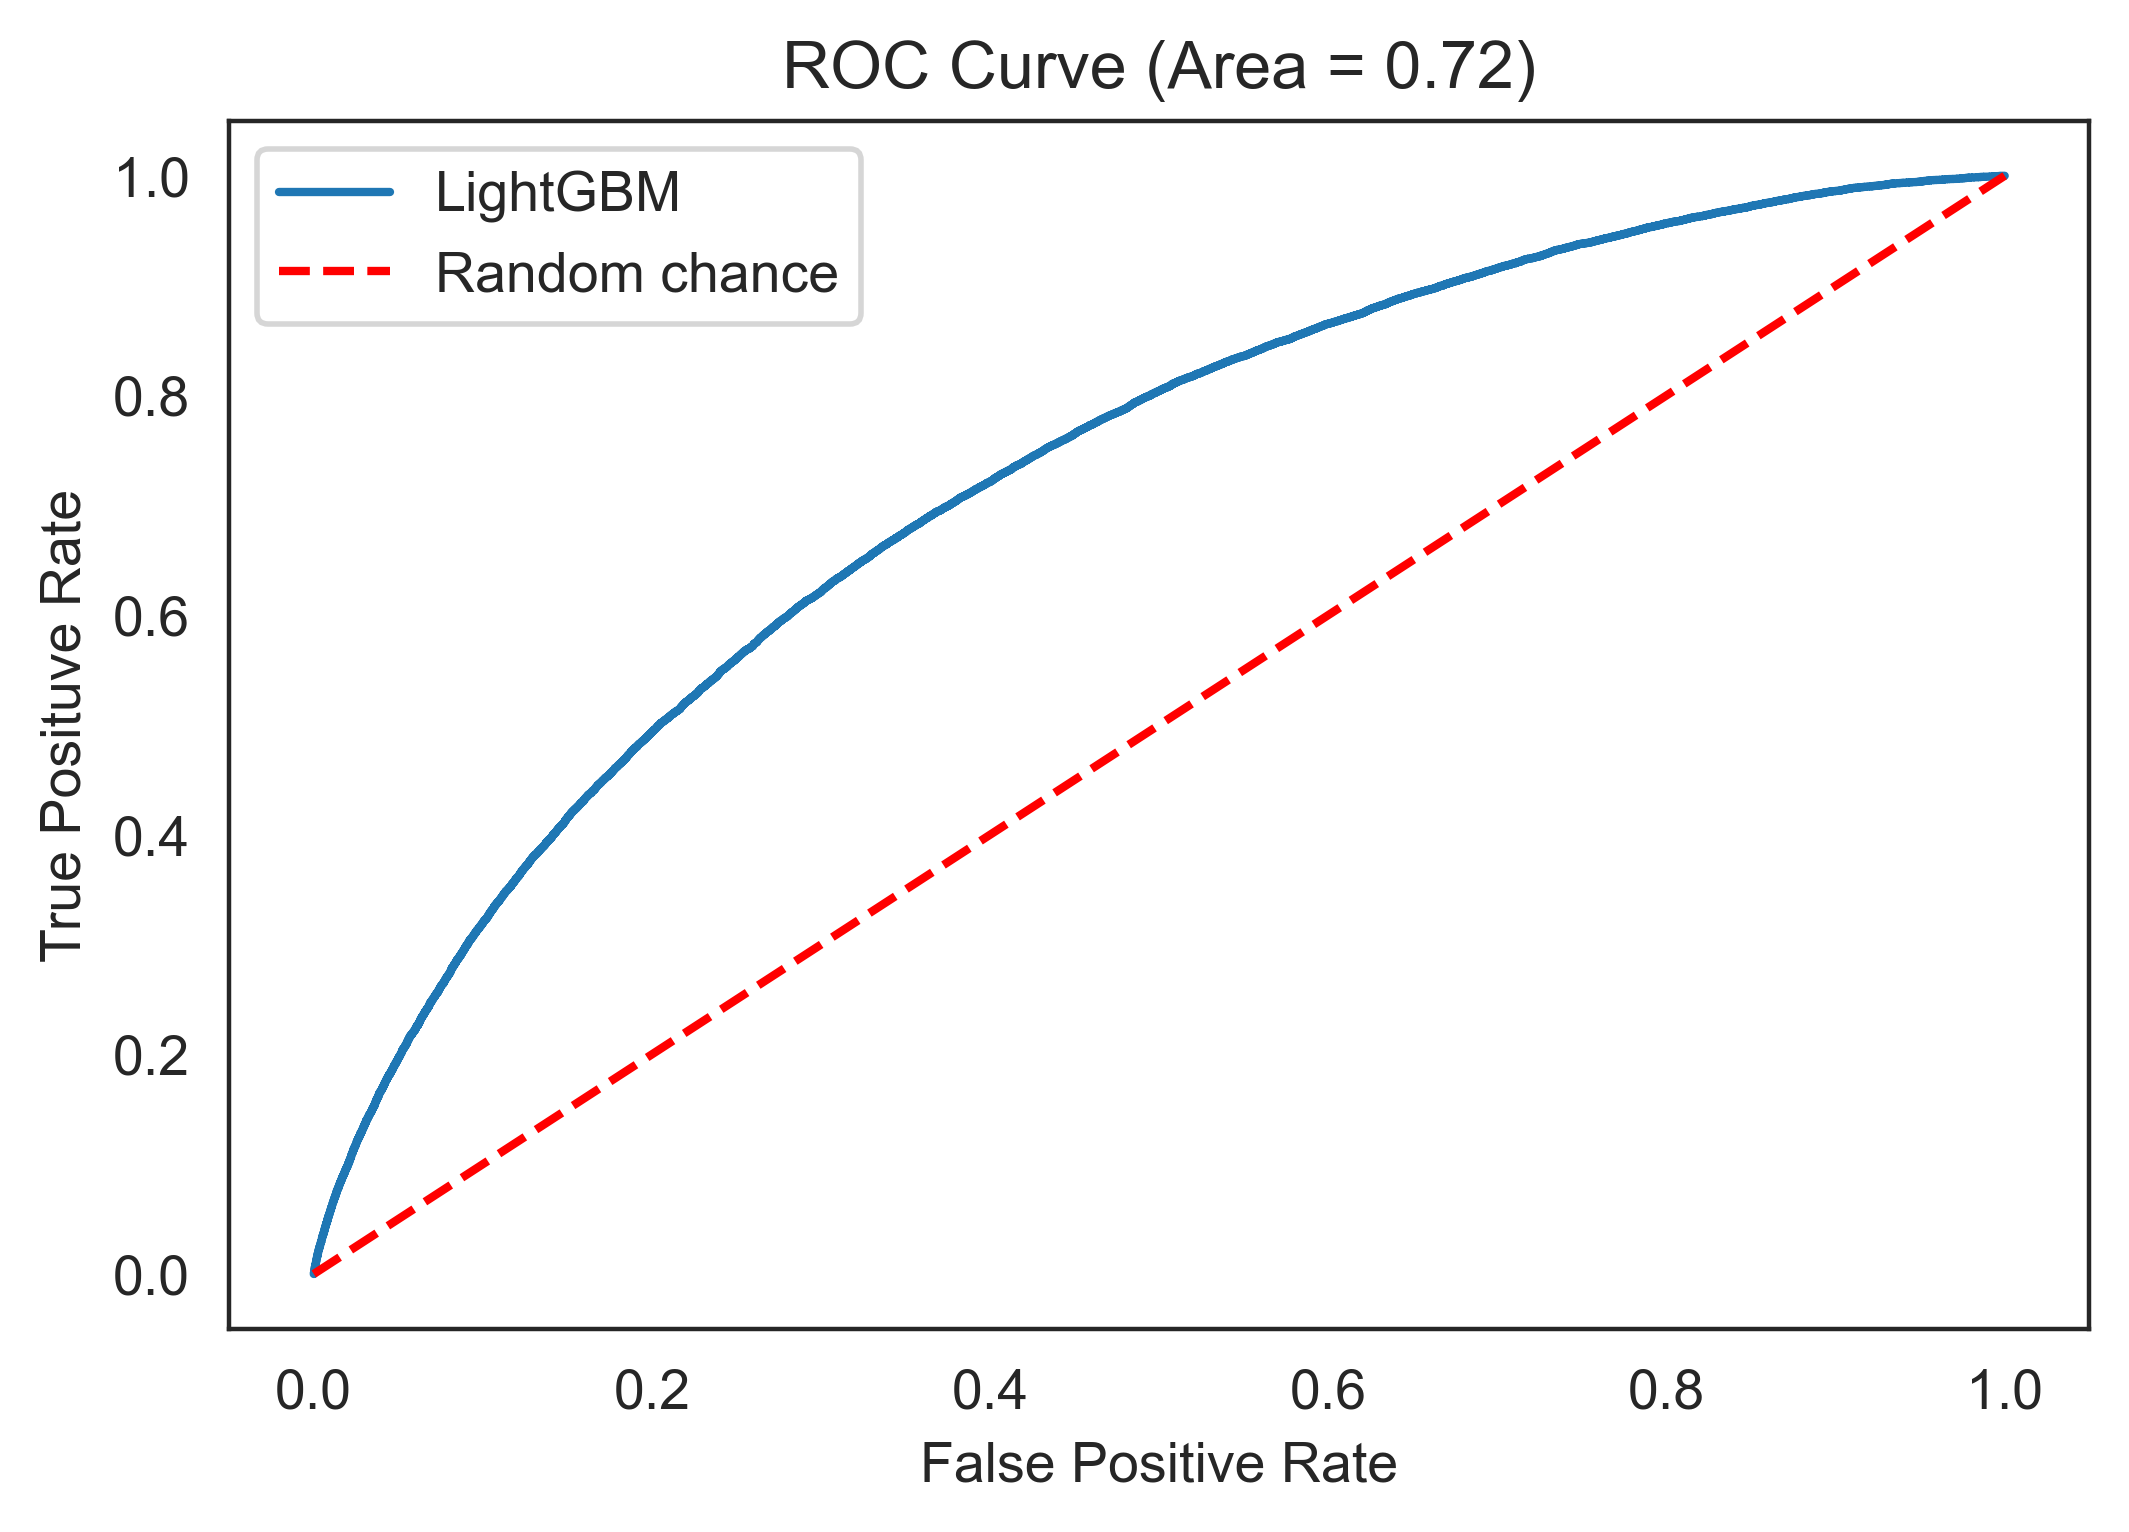

In [40]:
bal_roc_auc = roc_auc_score(y_test, pos_bal_proba)
plt.plot(bal_fpr, bal_tpr, '-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['LightGBM', 'Random chance'])
plt.xlabel('False Positive Rate')
plt.ylabel('True Posituve Rate')
plt.title('ROC Curve (Area = {:.2f})'.format(bal_roc_auc))

In [41]:
bal_precision, bal_recall, bal_thresh_3 = metrics.precision_recall_curve(y_test, pos_bal_proba)

(0.0, 1.0)

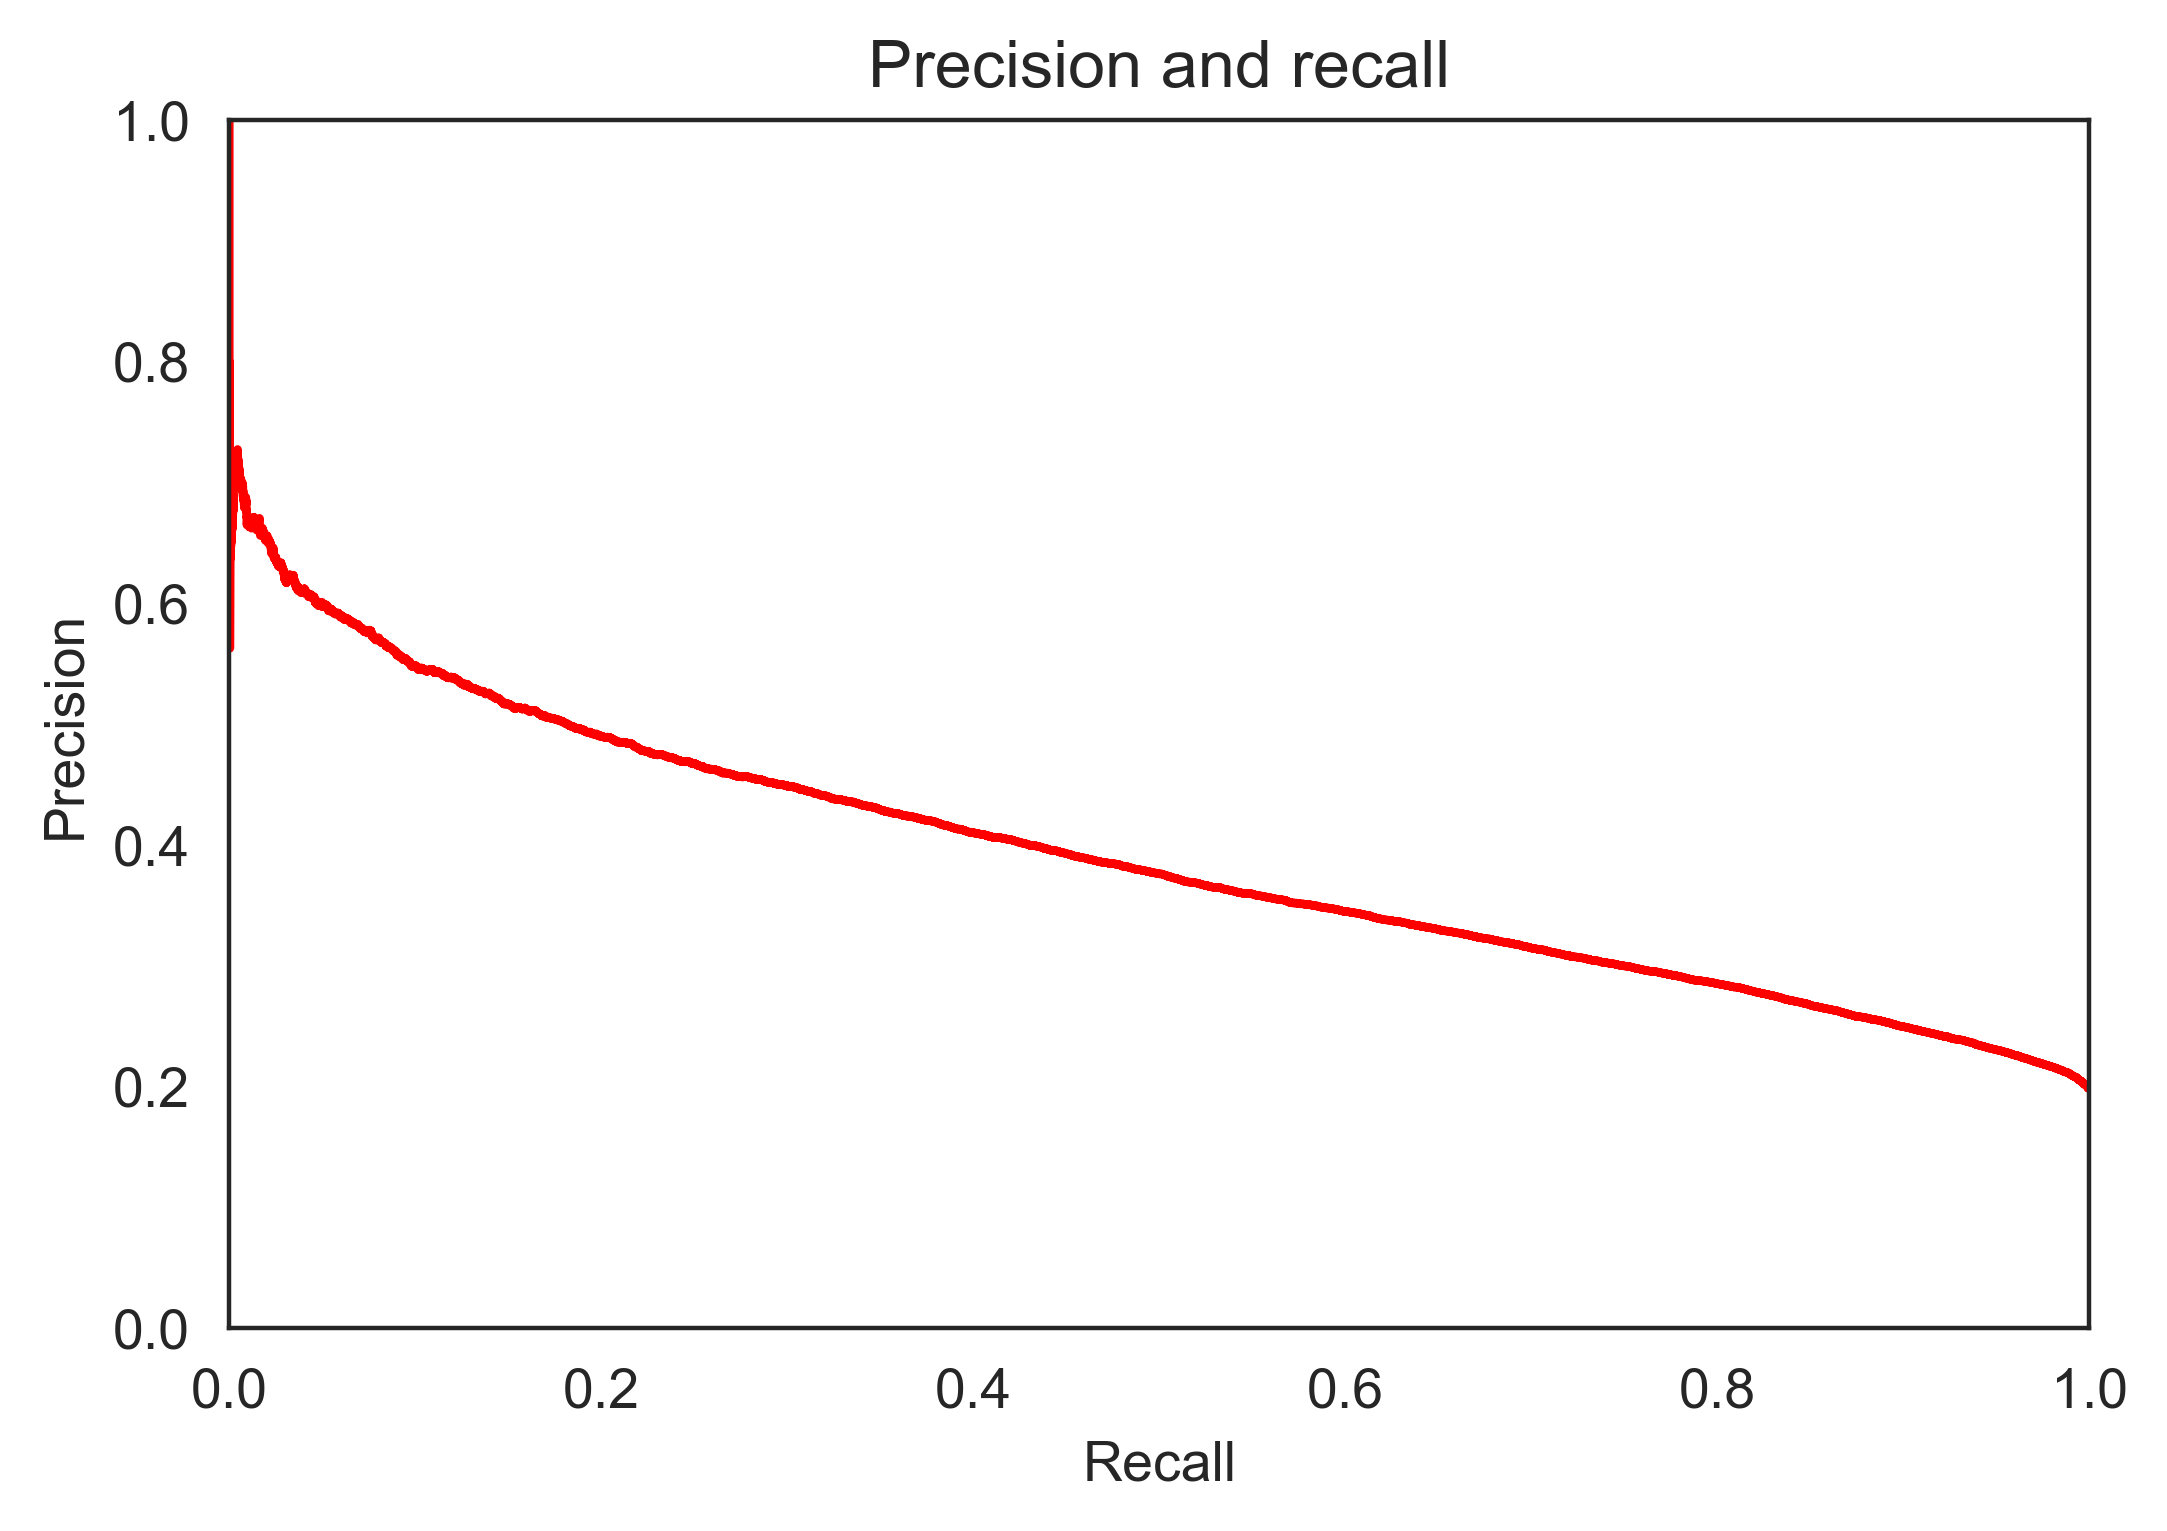

In [42]:
plt.plot(bal_recall, bal_precision, 'r-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and recall')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [43]:
metrics.auc(bal_recall, bal_precision)

0.39016771911291187

### Upsample the minority class
One of the popular techniques for dealing with highly unbalanced data sets is called resampling. Although the technique has proven to be effective in many cases to solve the unbalanced class issue, however, these techniques also have their weaknesses. For example, over-sampling records from the minority class, which can lead to overfitting while removing random records from the majority class, which can cause loss of information. 

- first separate classes into two data frames: 1. df_major and 2. df_minor. 
- Then use df_minor to upsample it to the same number as the major class which is 937174. 
- For upsamping set the replace optio to True. that I keep the replace option to true. 
- If we were downsampled then set the option to replace option to false. 
- Finally, concatenate the upsampled minor class with major class. 
- Now the charged_off counts are same.

In [44]:
df['sub_grade'] = df.sub_grade.cat.codes
df['sub_grade'].value_counts().head()

10    74058
8     71951
9     70929
7     69698
11    68707
Name: sub_grade, dtype: int64

In [45]:
df['purpose'] = df.purpose.cat.codes
df['purpose'].value_counts().head()

2    688528
1    257671
4     75071
9     64186
6     23810
Name: purpose, dtype: int64

In [46]:
df['home_ownership'] = df.home_ownership.cat.codes
df['home_ownership'].value_counts()

0    590610
3    457153
2    119852
1       337
Name: home_ownership, dtype: int64

In [47]:
df['addr_state'] = df.addr_state.cat.codes
df['addr_state'].value_counts().head()

4     168531
43     98806
34     90308
9      80713
14     45266
Name: addr_state, dtype: int64

In [48]:
df['verification_status'] = df.verification_status.cat.codes
df['verification_status'].value_counts().head()

1    475971
0    352976
2    339005
Name: verification_status, dtype: int64

In [49]:
df['initial_list_status'] = df.initial_list_status.cat.codes
df['initial_list_status'].value_counts().head()

1    718523
0    449429
Name: initial_list_status, dtype: int64

In [50]:
df['application_type'] = df.application_type.cat.codes
df['application_type'].value_counts().head()

0    1146425
1      21527
Name: application_type, dtype: int64

In [51]:
df_major = df[df.charged_off == 0]
df_minor = df[df.charged_off == 1]

In [52]:
df_minor_upsmapled = resample(df_minor, replace = True, n_samples = 937174, random_state = 1022)

In [53]:
df_minor_upsmapled = pd.concat([df_minor_upsmapled, df_major])

In [54]:
df_minor_upsmapled.charged_off.value_counts()

1    937174
0    937174
Name: charged_off, dtype: int64

In [55]:
X = df_minor_upsmapled.drop('charged_off', axis = 1)
y = df_minor_upsmapled.charged_off

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1023, stratify = y)

In [57]:
mms = StandardScaler()
mms.fit(X_train)
X_train_scaled = mms.transform(X_train)

In [58]:
np.shape(df_minor_upsmapled)

(1874348, 22)

In [59]:
lgb2_params = {
    'n_estimators': 8000,
    'max_depth': 63,
    'objective': 'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 250,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 1,
    'boosting_type' : 'gbdt'
}

In [60]:
lgbm2 = lgb.LGBMClassifier(**lgb2_params)

In [61]:
lgbm2.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.8, bagging_freq=1, feature_fraction=0.64,
               learning_rate=0.02, max_depth=63, n_estimators=8000,
               num_leaves=250, objective='binary')

<AxesSubplot:>

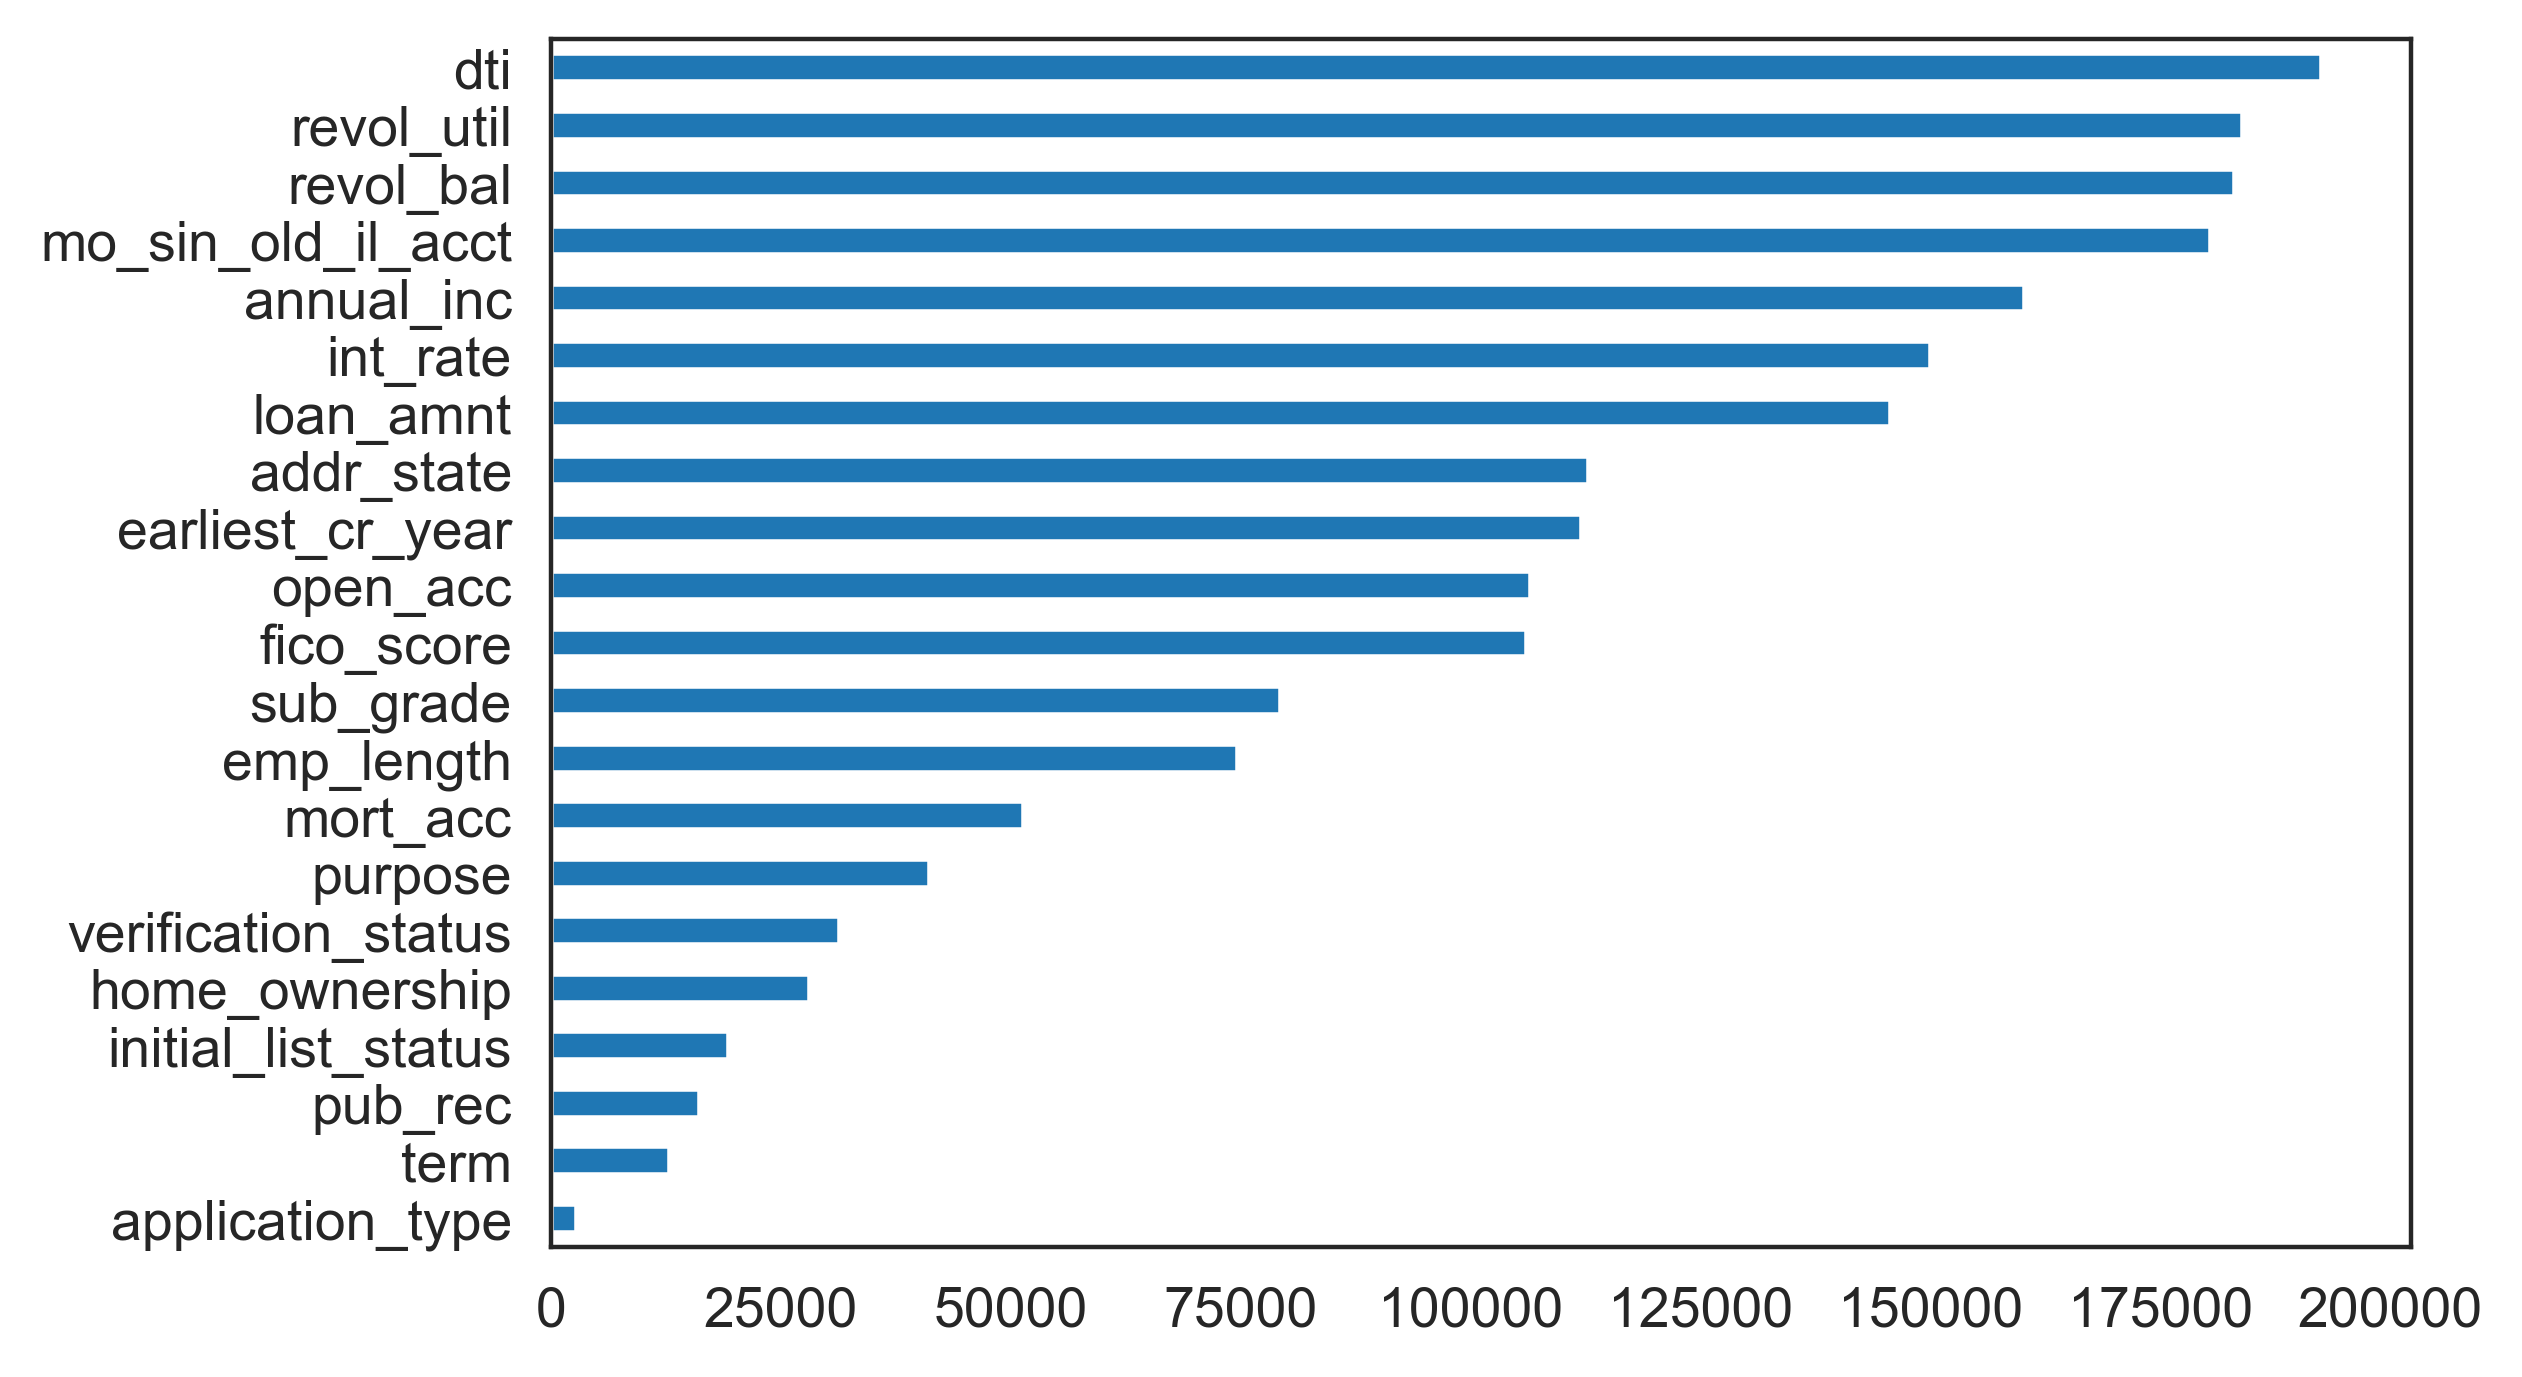

In [62]:
feat_imp = pd.Series(lgbm2.feature_importances_, index=X.columns)
feat_imp.nsmallest(21).plot(kind='barh')

In [63]:
lgb2_pred = lgbm2.predict(X_test)

In [64]:
lgb2_pred_proba = lgbm2.predict_proba(X_test)

In [65]:
evaluate_model(y_test, lgb2_pred, lgb2_pred_proba)

ROC-AUC score of the model: 0.9109393615966166
Accuracy of the model: 0.8318830527916344

Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.78      0.82     93717
           1       0.80      0.88      0.84     93718

    accuracy                           0.83    187435
   macro avg       0.84      0.83      0.83    187435
weighted avg       0.84      0.83      0.83    187435


Confusion matrix: 
[[73275 20442]
 [11069 82649]]



In [66]:
pos_proba = lgb2_pred_proba[:,1]
pos_proba

array([0.72062055, 0.27675314, 0.28512168, ..., 0.7623892 , 0.89207612,
       0.45305591])

In [67]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_proba)

Text(0.5, 1.0, 'ROC Curve (Area = 0.91)')

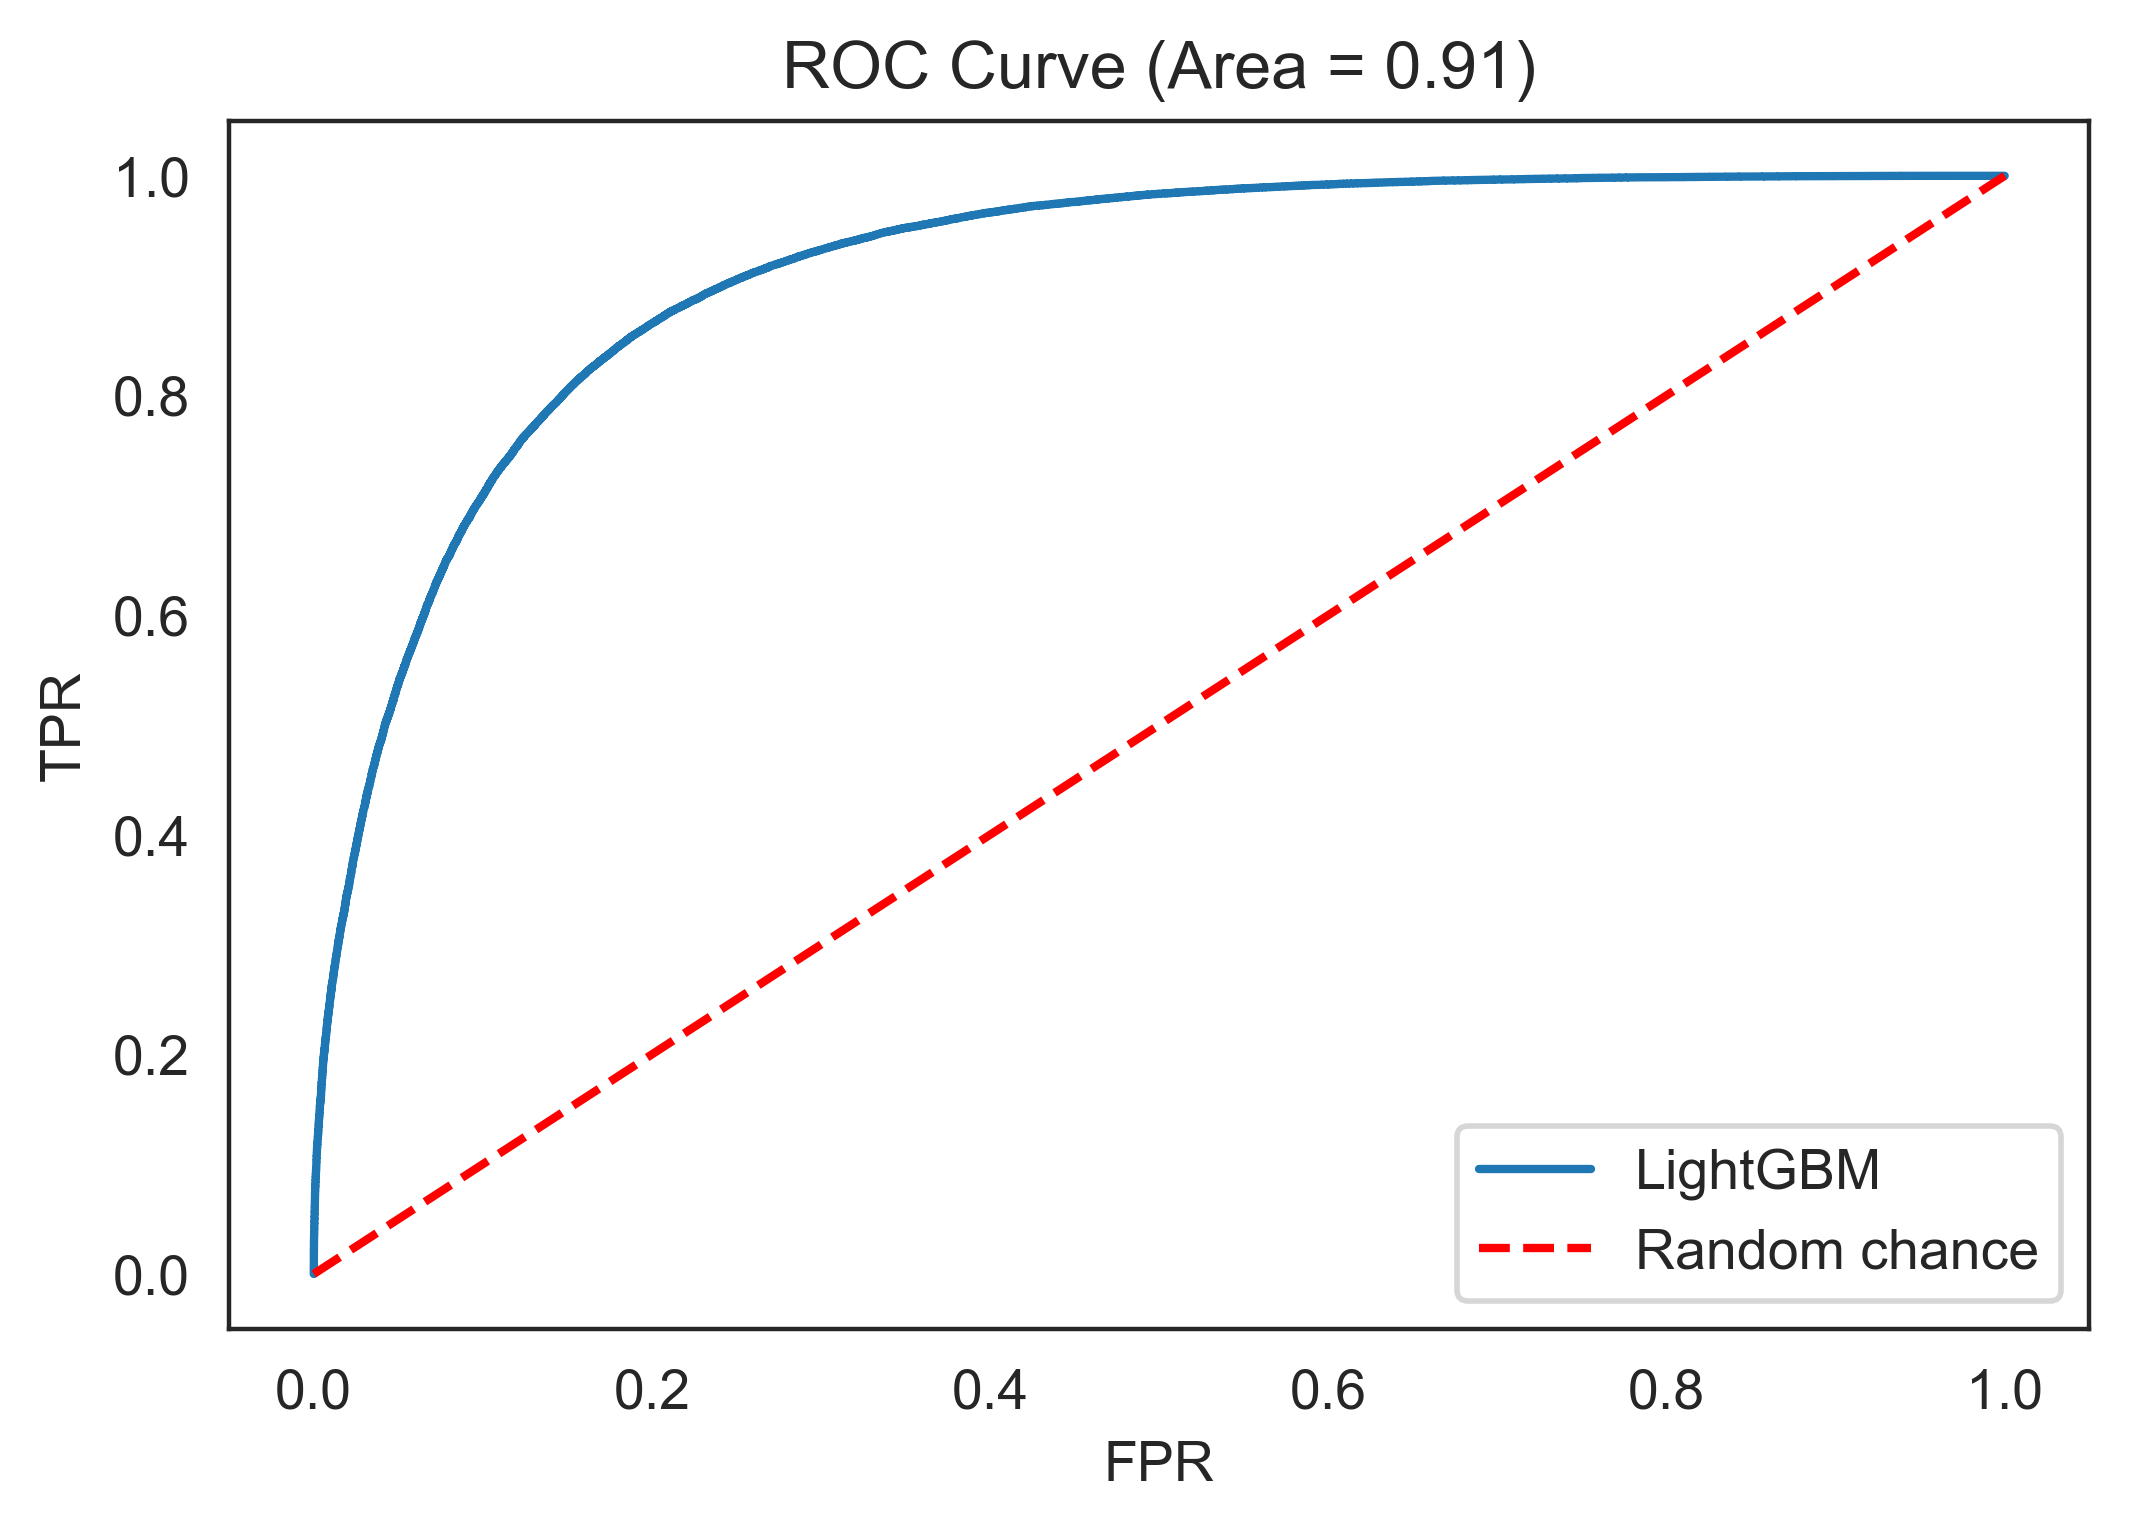

In [68]:
roc_auc = roc_auc_score(y_test, pos_proba)
plt.plot(fpr, tpr, '-')
plt.plot([0, 1], [0, 1], 'r--')
plt.legend(['LightGBM', 'Random chance'])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (Area = {:.2f})'.format(roc_auc))

In [69]:
thresholds

array([1.98332133e+00, 9.83321326e-01, 9.77105467e-01, ...,
       3.71007894e-02, 3.70862662e-02, 9.01495360e-04])

In [70]:
precision, recall, thresh_3 = metrics.precision_recall_curve(y_test, pos_proba)

(0.0, 1.0)

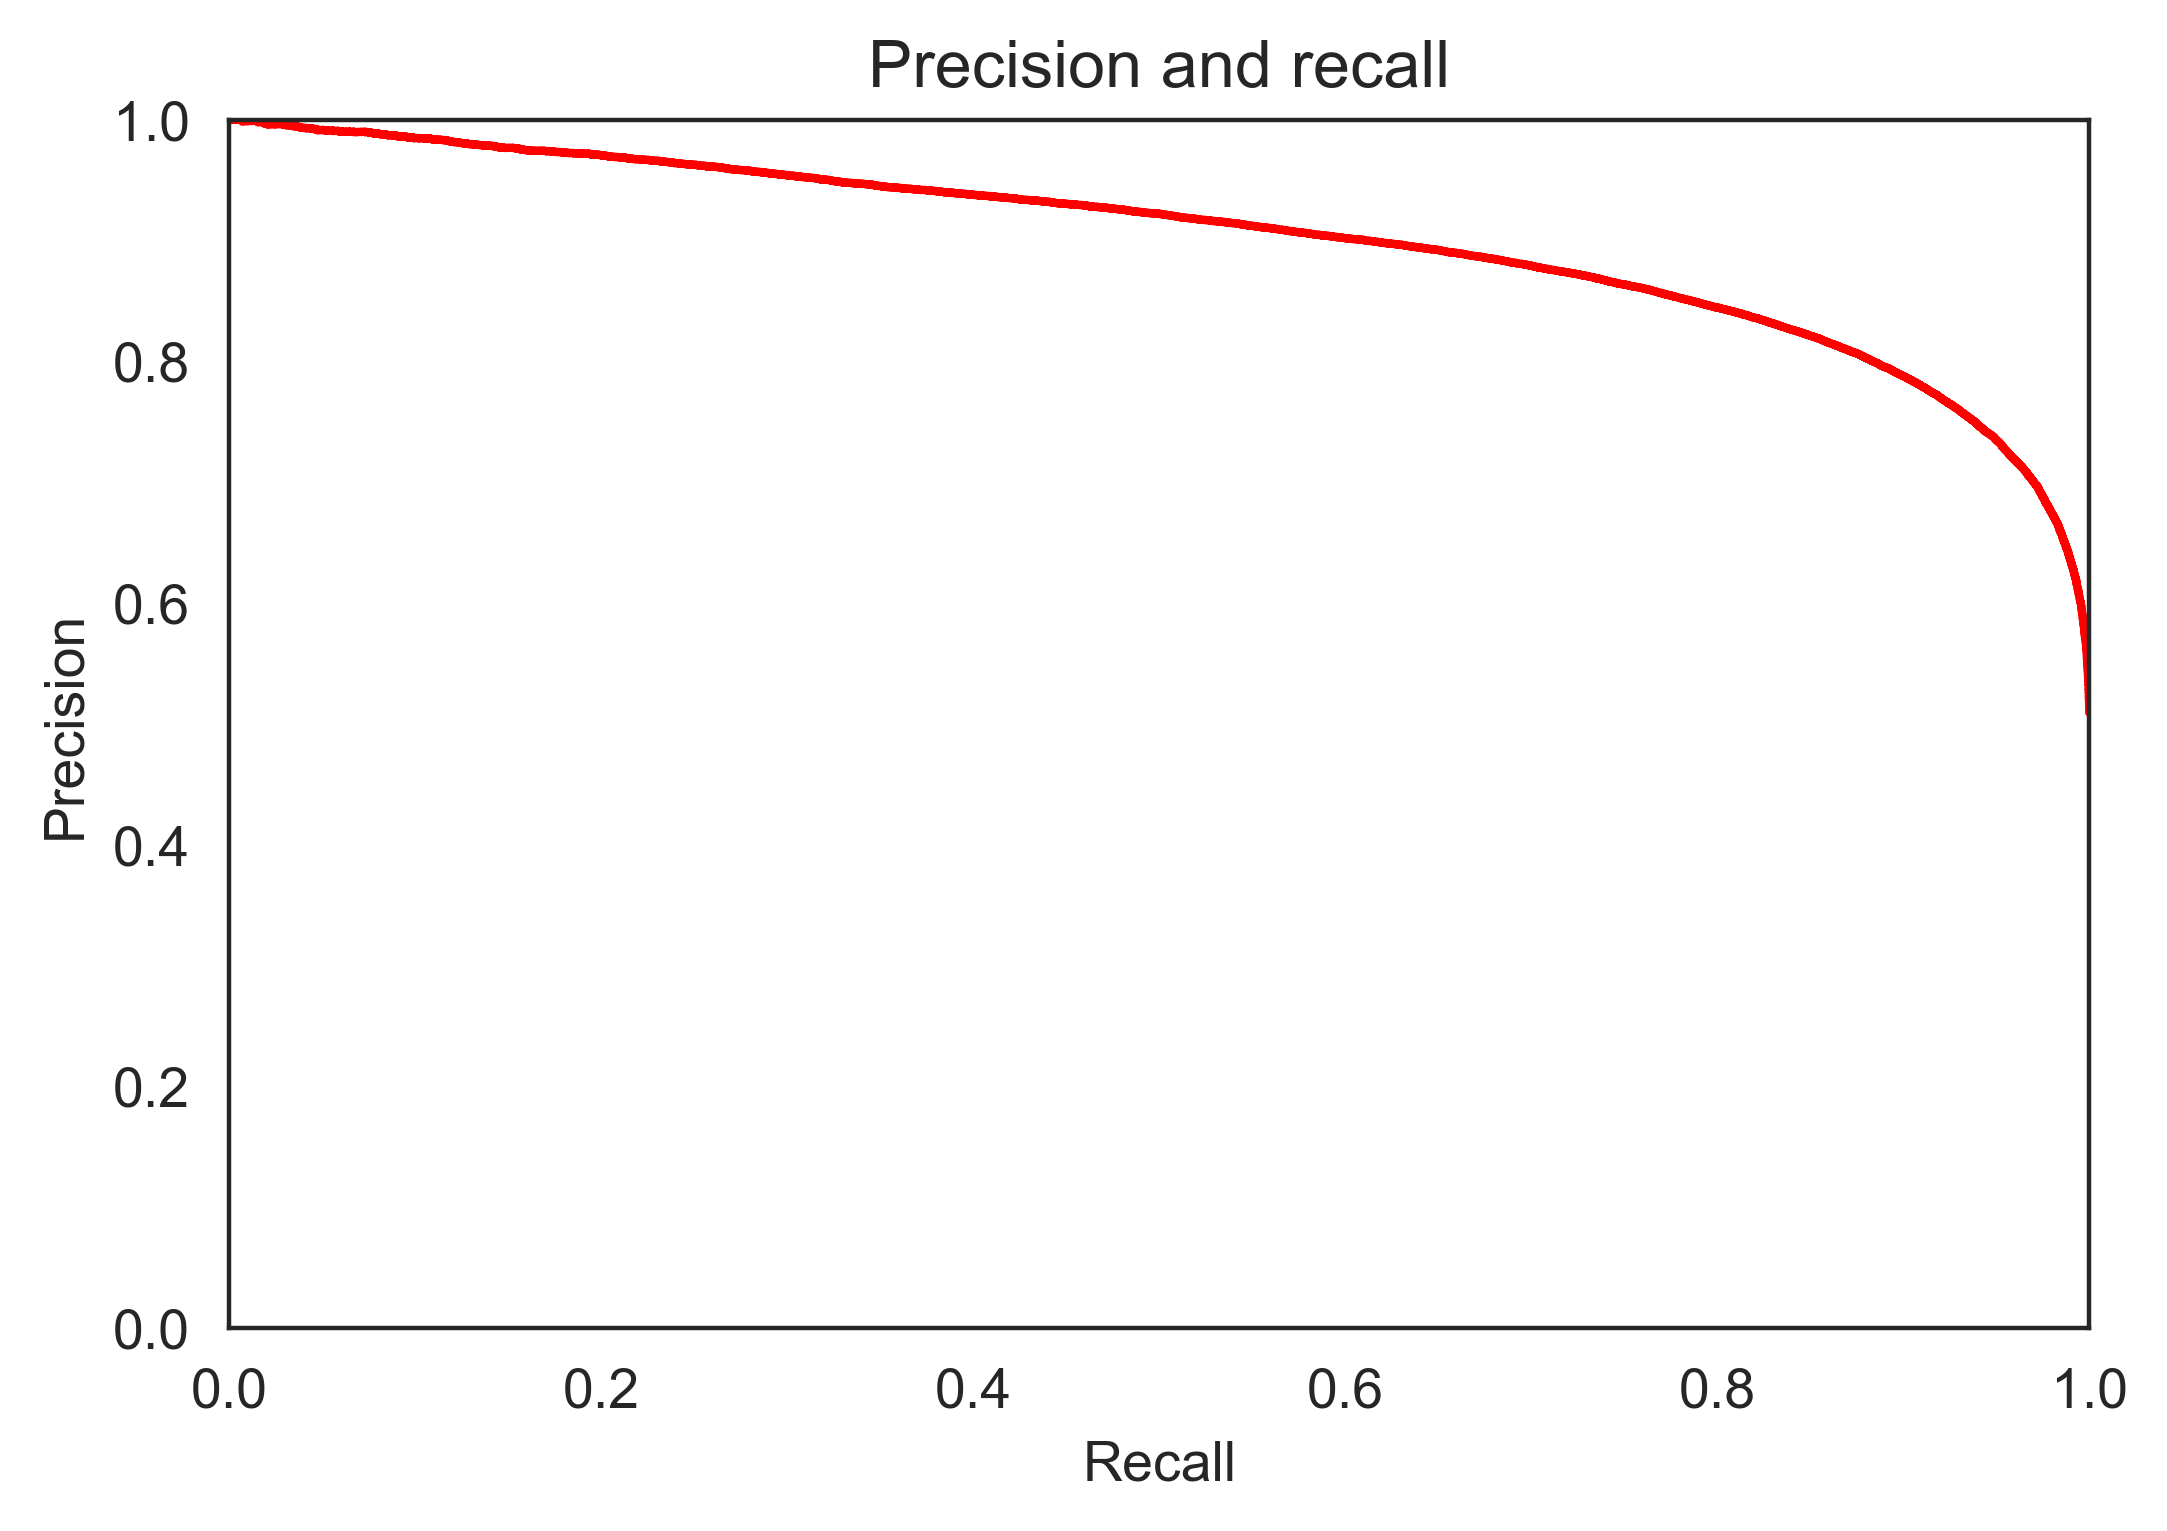

In [71]:
plt.plot(recall, precision, 'r-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision and recall')
plt.xlim([0, 1])
plt.ylim([0, 1])

In [72]:
metrics.auc(recall, precision)

0.9014936262853664

**Cross validation**

In [93]:
folds = list(KFold(5, shuffle=True, random_state=1023)\
             .split(X_train_scaled, y_train))

In [96]:
for i, (train_idx, valid_idx) in enumerate(folds):
    
    y_train = np.array(y_train)
    X_train_x = X_train_scaled[train_idx]
    y_train_x = y_train[train_idx]
    X_valid = X_train_scaled[valid_idx]
    y_valid = y_train[valid_idx]
    
    lgbm2.fit(X_train_x, y_train_x)
    pred = lgbm2.predict(X_valid)
    pred_proba = lgbm2.predict_proba(X_valid)
    
    print('\ncv: {}\n'.format(i))
    evaluate_model(y_valid, pred, pred_proba)

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1

cv: 0

ROC-AUC score of the model: 0.9047665918991787
Accuracy of the model: 0.8245317636039753

Classification report: 
              precision    recall  f1-score   support

           0       0.86      0.78      0.82    168609
           1       0.80      0.87      0.83    168774

    accuracy                           0.82    337383
   macro avg       0.83      0.82      0.82    337383
weighted avg       0.83      0.82      0.82    337383


Confusion matrix: 
[[130724  37885]
 [ 21315 147459]]

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warnin

**Conclusion:** As we notice the model's performance is consistent across different training folds.